In [1]:
class Probe:
    def __init__(self, name, values):
        self.name = name
        if isinstance(values, dict):
            # Modify the dictionary to change "from" to "from_ip"
            modified_values = {("from_ip" if k == "from" else k): v for k, v in values.items()}
            self.__dict__.update(modified_values)
            self.country = get_probe_country(self.prb_id)
        else:
            raise TypeError("Expected a dictionary")

class Destination:
    def __init__(self, name):
        self.name = name
        self.probes = []

    def add_probe(self, probe):
        if isinstance(probe, Probe):
            self.probes.append(probe)
        else:
            raise TypeError("Expected a Probe instance")

In [2]:
import pickle
import os

pickle_file_path = os.path.join(os.getcwd(), "destinations.pickle")
with open(pickle_file_path, "rb") as pickle_file:
    destinations = pickle.load(pickle_file)

In [3]:
from collections import defaultdict

destination_country_probes = defaultdict(lambda: defaultdict(list))

for destination in destinations.values():
    print(f"Destination: {destination.name}")
    for probe in destination.probes:
        destination_country_probes[destination.name][probe.country].append(probe)

Destination: bet365
Destination: betnacional
Destination: betway


In [4]:
# Define the countries by continent
continents = {
    "South America": ["BR", "UY", "CL"],
    "Asia": ["CN", "MN", "IN"],
    "North America": ["US", "CN", "MX"]
}

probes_by_continent_country = {
    continent: {country: set() for country in countries}
    for continent, countries in continents.items()
}

# Iterate over all destinations and their probes
for destination_name, destination in destinations.items():
    for probe in destination.probes:
        # Check which continent and country the probe's country belongs to
        for continent, countries in continents.items():
            if probe.country in countries:
                probes_by_continent_country[continent][probe.country].add(probe.prb_id)  # Use 'add' to avoid duplicates

# Print probe IDs for each continent and country
for continent, countries in probes_by_continent_country.items():
    print(f"{continent}:")
    for country, probe_ids in countries.items():
        print(f"  {country}: {list(probe_ids)}")

South America:
  BR: [12808, 28708, 65373, 1005287]
  UY: [17826, 1003171, 23526, 1004969, 7147, 21559]
  CL: [7308, 6554, 30139, 1007645, 1007198, 51486]
Asia:
  CN: [1008244, 63018, 1006180]
  MN: [61872, 6723, 62788]
  IN: [60592, 60289, 61030]
North America:
  US: [62226, 60822, 51350]
  CN: [1008244, 63018, 1006180]
  MX: [63001, 65083, 1003249, 25182]


1. Variação da Latência ao Longo do Tempo

a. Comparação das latências das probes para um mesmo destino

In [101]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

def plot_rtt_comparison(destination_country_probes, destination, min_rtt=2):
    """
    Plots the average RTT over time for multiple countries for a specified destination,
    grouped into 2-hour intervals.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - destination: The destination for which to plot the RTT data.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    """
    from math import floor

    # Helper function to bin timestamps into 2-hour intervals
    def bin_timestamp_to_interval(timestamp, interval_hours=2):
        interval_seconds = interval_hours * 3600
        return floor(timestamp / interval_seconds) * interval_seconds

    interval_rtt_by_country = defaultdict(lambda: defaultdict(list))  # Dictionary for storing RTTs

    # Collect RTT data for the specified destination
    for country_code, probes in destination_country_probes.get(destination, {}).items():
        if not any(country_code in countries for countries in continents.values()):
                continue
        for probe in probes:
            if probe.result and probe.result[-1].get("result"):
                rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                timestamp = probe.timestamp
                if rtt > min_rtt:  # Only consider RTTs greater than the specified minimum RTT
                    interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp
                    interval_rtt_by_country[country_code][interval_timestamp].append(rtt)

    # Calculate the average RTT for each 2-hour interval for each country
    average_rtt_by_country = defaultdict(dict)
    for country_code, intervals in interval_rtt_by_country.items():
        for timestamp, rtts in intervals.items():
            average_rtt_by_country[country_code][timestamp] = sum(rtts) / len(rtts)

    # Plot data
    plt.figure(figsize=(12, 6))
    
    for country_code, avg_rtt in average_rtt_by_country.items():
        sorted_timestamps = sorted(avg_rtt.keys())
        sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
        sorted_rtts = [avg_rtt[timestamp] for timestamp in sorted_timestamps]
        plt.plot(sorted_times, sorted_rtts, linestyle='-', label=f'{country_code} RTT')

    # Format the x-axis to display date and time correctly
    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Labels and formatting
    plt.xlabel('Time (2-hour intervals)')
    plt.ylabel('Average RTT (ms)')
    plt.title(f'Average RTT per 2-hour Interval for Destination: {destination}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

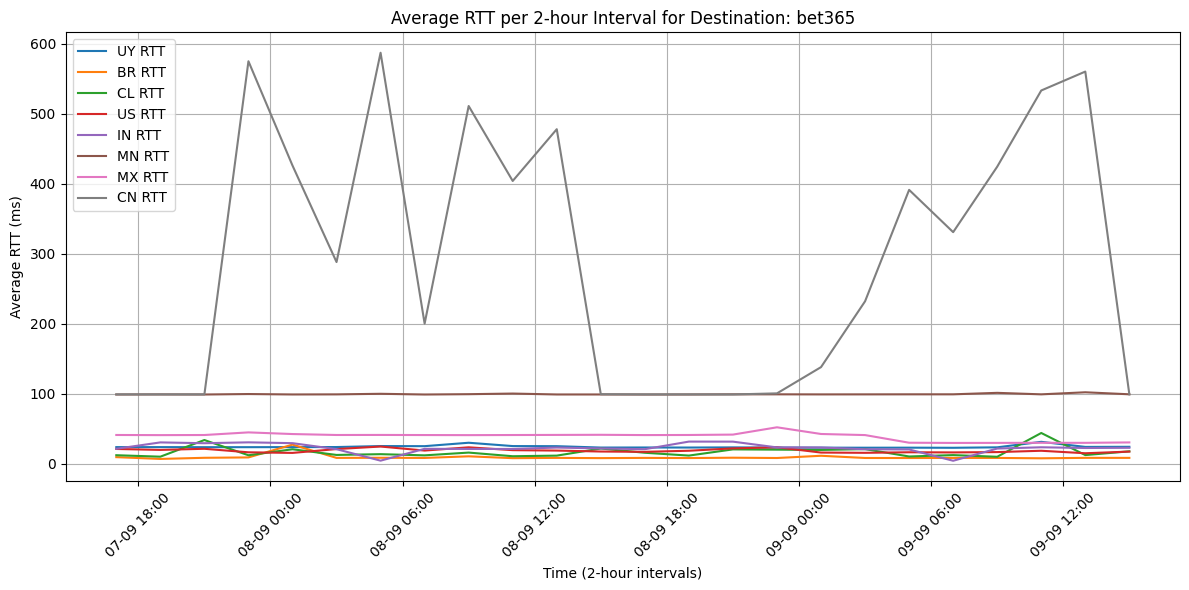

In [102]:
plot_rtt_comparison(destination_country_probes, "bet365", min_rtt=0)

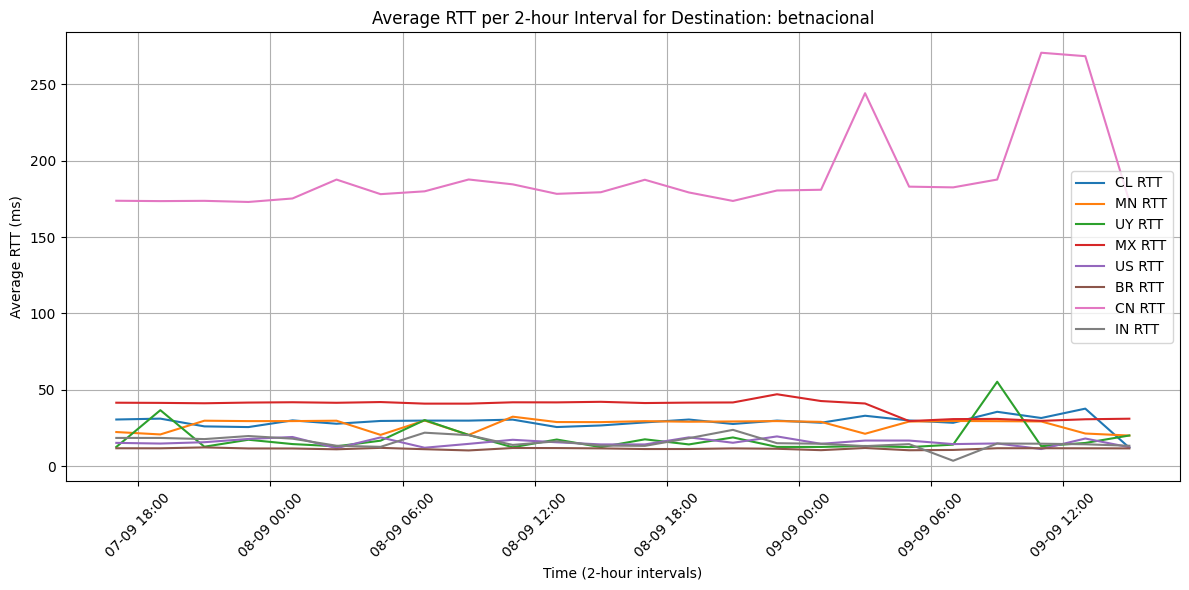

In [103]:
plot_rtt_comparison(destination_country_probes, "betnacional", min_rtt=2)

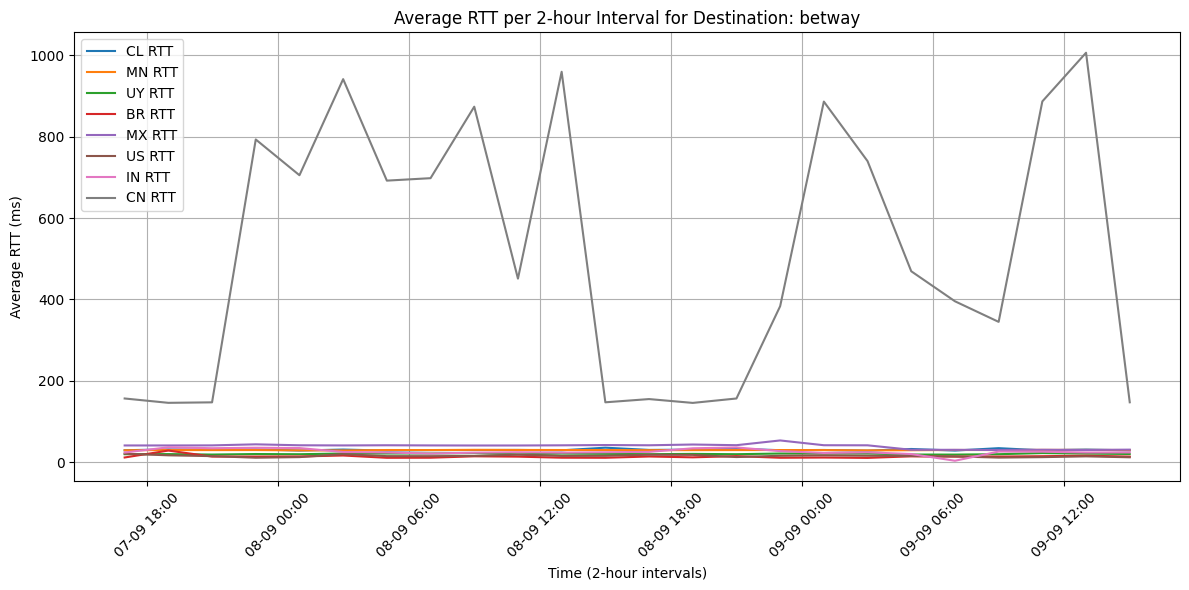

In [104]:
plot_rtt_comparison(destination_country_probes, "betway", min_rtt=2)

b. Comparação das latências para todos os destinos medidos

In [18]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

def plot_rtt_for_all_destinations(destination_country_probes, min_rtt=2):
    """
    Plots the average RTT over time for all destinations, grouped into 2-hour intervals.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    """
    from math import floor

    # Helper function to bin timestamps into 2-hour intervals
    def bin_timestamp_to_interval(timestamp, interval_hours=2):
        interval_seconds = interval_hours * 3600
        return floor(timestamp / interval_seconds) * interval_seconds

    interval_rtt_by_destination = defaultdict(lambda: defaultdict(list))  # Dictionary for storing RTTs

    # Collect RTT data for all destinations
    for destination, countries in destination_country_probes.items():
        for country_code, probes in countries.items():
            for probe in probes:
                if probe.result and probe.result[-1].get("result"):
                    rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                    timestamp = probe.timestamp
                    if rtt > min_rtt:  # Only consider RTTs greater than the specified minimum RTT
                        interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp
                        interval_rtt_by_destination[destination][interval_timestamp].append(rtt)

    # Calculate the average RTT for each 2-hour interval for each destination
    average_rtt_by_destination = defaultdict(dict)
    for destination, intervals in interval_rtt_by_destination.items():
        for timestamp, rtts in intervals.items():
            average_rtt_by_destination[destination][timestamp] = sum(rtts) / len(rtts)

    # Plot data
    plt.figure(figsize=(12, 6))

    for destination, avg_rtt in average_rtt_by_destination.items():
        sorted_timestamps = sorted(avg_rtt.keys())
        sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
        sorted_rtts = [avg_rtt[timestamp] for timestamp in sorted_timestamps]
        plt.plot(sorted_times, sorted_rtts, linestyle='-', label=f'{destination} RTT')

    # Format the x-axis to display date and time correctly
    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Labels and formatting
    plt.xlabel('Time (2-hour intervals)')
    plt.ylabel('Average RTT (ms)')
    plt.title('Average RTT per 2-hour Interval for All Destinations')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

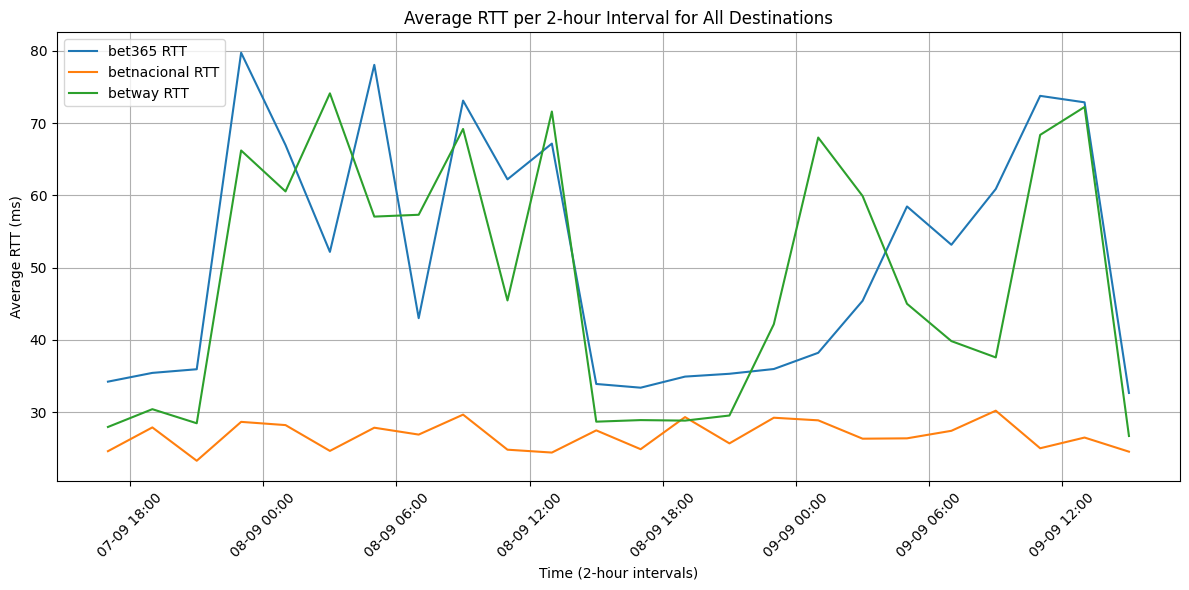

In [21]:
plot_rtt_for_all_destinations(destination_country_probes, min_rtt=0)

c. Gráficos por Continente e País

In [26]:
continents = {
    "South America": ["BR", "UY", "CL"],
    "Asia": ["CN", "MN", "IN"],
    "North America": ["US", "CN", "MX"]
}

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

def plot_rtt_by_continent(destination_country_probes, continents, min_rtt=2):
    """
    Plots the average RTT over time for each continent, grouped into 2-hour intervals.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - continents: A dictionary mapping continent names to lists of country codes.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    """
    from math import floor

    # Helper function to bin timestamps into 2-hour intervals
    def bin_timestamp_to_interval(timestamp, interval_hours=2):
        interval_seconds = interval_hours * 3600
        return floor(timestamp / interval_seconds) * interval_seconds

    # Reverse the continents dictionary for quick look-up
    country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}

    interval_rtt_by_continent = defaultdict(lambda: defaultdict(list))  # Dictionary for storing RTTs

    # Collect RTT data for each continent
    for destination, country_dict in destination_country_probes.items():
        for country_code, probes in country_dict.items():
            continent = country_to_continent.get(country_code)
            if not continent:
                continue  # Skip if continent information is not available

            for probe in probes:
                if hasattr(probe, 'result') and probe.result and probe.result[-1].get("result"):
                    rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                    timestamp = probe.timestamp
                    
                    if rtt > min_rtt and timestamp is not None:  # Only consider RTTs greater than the specified minimum RTT
                        interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp
                        interval_rtt_by_continent[continent][interval_timestamp].append(rtt)

    # Calculate the average RTT for each 2-hour interval for each continent
    average_rtt_by_continent = defaultdict(dict)
    for continent, intervals in interval_rtt_by_continent.items():
        for timestamp, rtts in intervals.items():
            average_rtt_by_continent[continent][timestamp] = sum(rtts) / len(rtts)

    # Plot data
    plt.figure(figsize=(12, 6))

    for continent, avg_rtt in average_rtt_by_continent.items():
        sorted_timestamps = sorted(avg_rtt.keys())
        sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
        sorted_rtts = [avg_rtt[timestamp] for timestamp in sorted_timestamps]
        plt.plot(sorted_times, sorted_rtts, linestyle='-', label=f'{continent} RTT')

    # Format the x-axis to display date and time correctly
    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Labels and formatting
    plt.xlabel('Time (2-hour intervals)')
    plt.ylabel('Average RTT (ms)')
    plt.title('Average RTT per 2-hour Interval by Continent')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [41]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

continents = {
    "South America": ["BR", "UY", "CL"],
    "Asia": ["CN", "MN", "IN"],
    "North America": ["US", "CN", "MX"]
}

def plot_rtt_by_country(destination_country_probes, min_rtt=2):
    """
    Plots the average RTT over time for each country, grouped into 2-hour intervals.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    """
    from math import floor

    # Helper function to bin timestamps into 2-hour intervals
    def bin_timestamp_to_interval(timestamp, interval_hours=2):
        interval_seconds = interval_hours * 3600
        return floor(timestamp / interval_seconds) * interval_seconds

    interval_rtt_by_country = defaultdict(lambda: defaultdict(list))  # Dictionary for storing RTTs

    # Collect RTT data for each country
    for destination, countries in destination_country_probes.items():
        for country_code, probes in countries.items():
            if not any(country_code in countries for countries in continents.values()):
                continue
            for probe in probes:
                if probe.result and probe.result[-1].get("result"):
                    rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                    timestamp = probe.timestamp
                    if rtt > min_rtt:  # Only consider RTTs greater than the specified minimum RTT
                        interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp
                        interval_rtt_by_country[country_code][interval_timestamp].append(rtt)

    # Calculate the average RTT for each 2-hour interval for each country
    average_rtt_by_country = defaultdict(dict)
    for country_code, intervals in interval_rtt_by_country.items():
        for timestamp, rtts in intervals.items():
            average_rtt_by_country[country_code][timestamp] = sum(rtts) / len(rtts)

    # Plot data
    for country_code, avg_rtt in average_rtt_by_country.items():
        plt.figure(figsize=(12, 6))
        sorted_timestamps = sorted(avg_rtt.keys())
        sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
        sorted_rtts = [avg_rtt[timestamp] for timestamp in sorted_timestamps]
        plt.plot(sorted_times, sorted_rtts, linestyle='-', color='b', label=f'{country_code} RTT')

        # Format the x-axis to display date and time correctly
        ax = plt.gca()  # Get current axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        # Labels and formatting
        plt.xlabel('Time (2-hour intervals)')
        plt.ylabel('Average RTT (ms)')
        plt.title(f'Average RTT per 2-hour Interval for {country_code}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

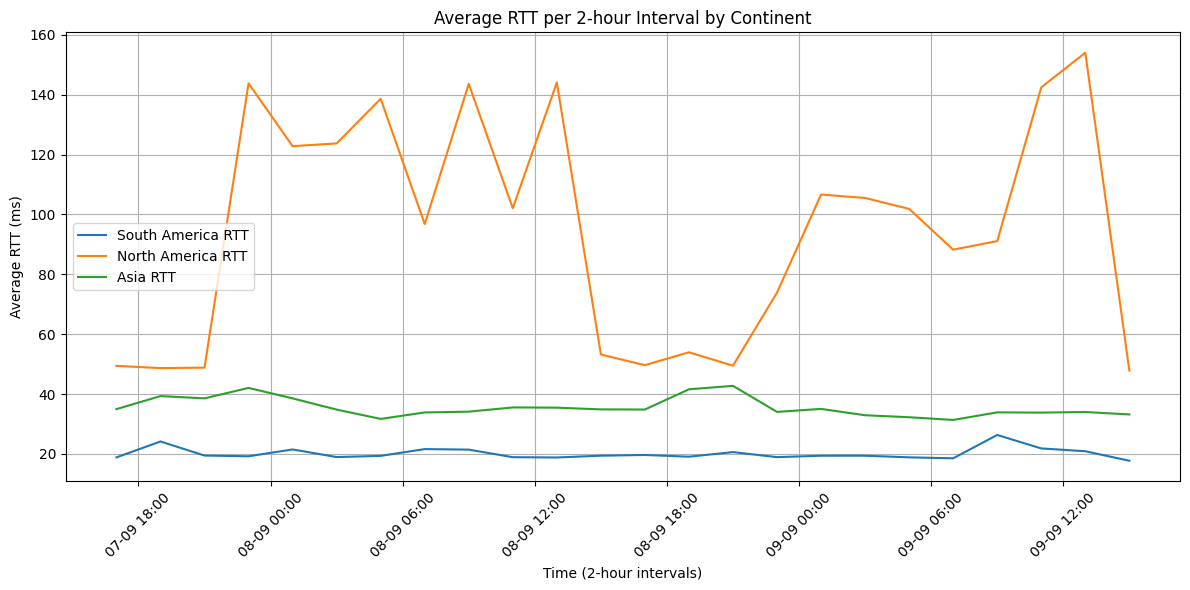

In [35]:
plot_rtt_by_continent(destination_country_probes, continents=continents, min_rtt=0)

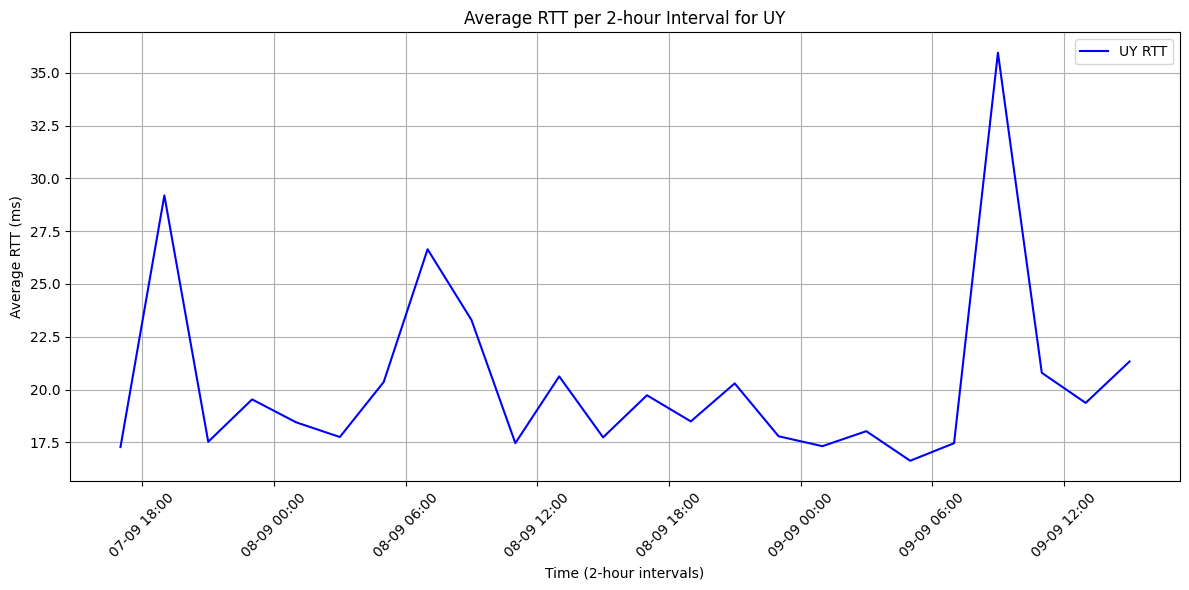

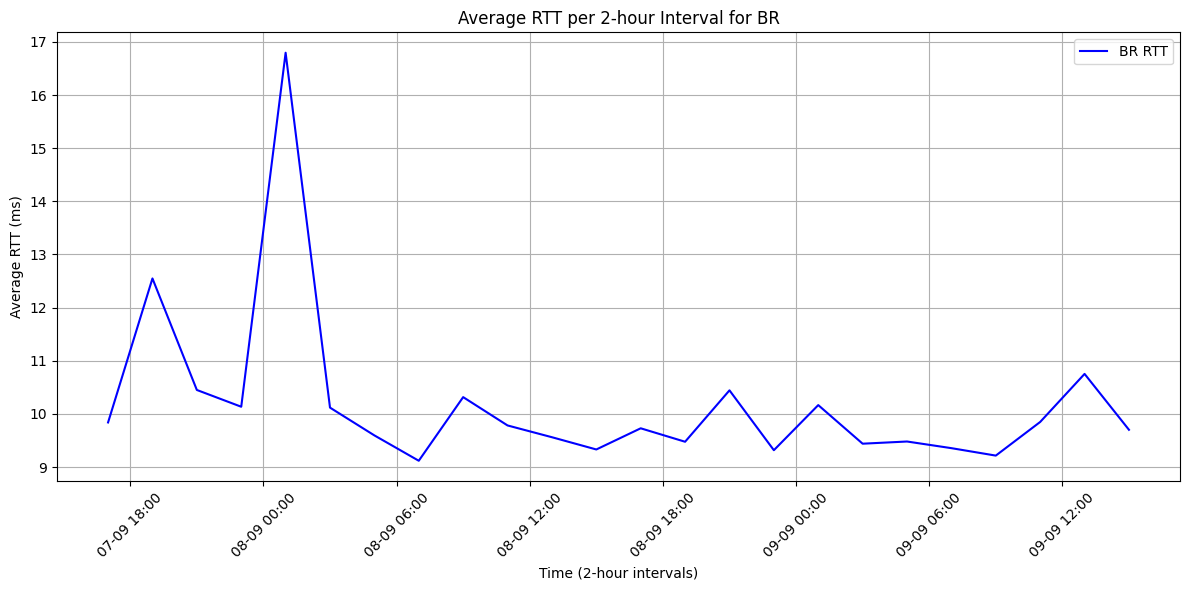

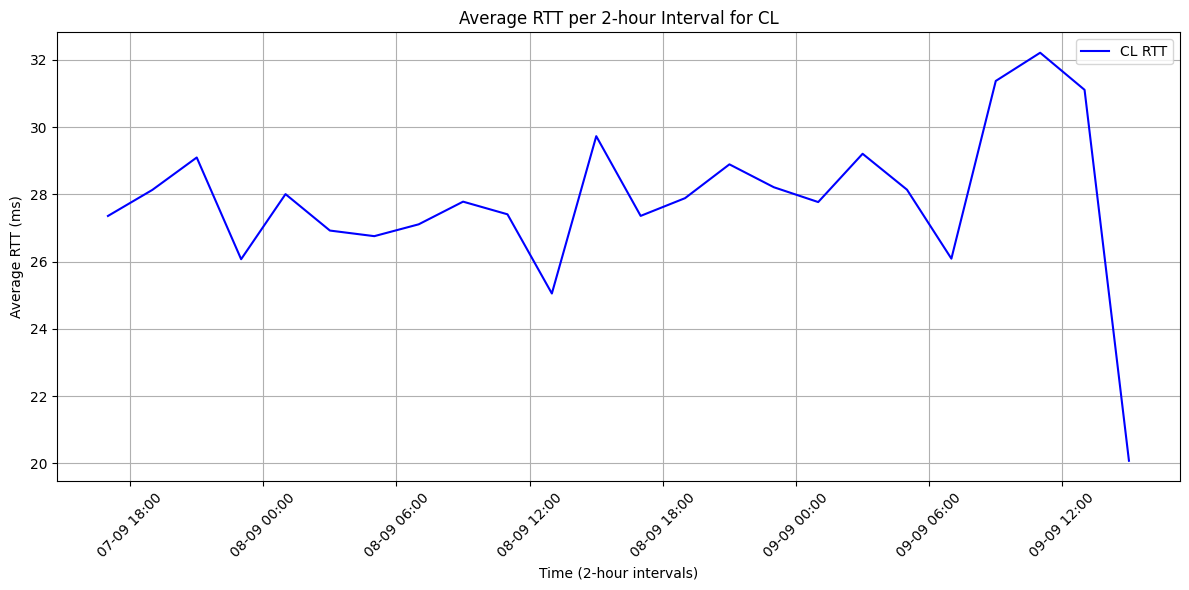

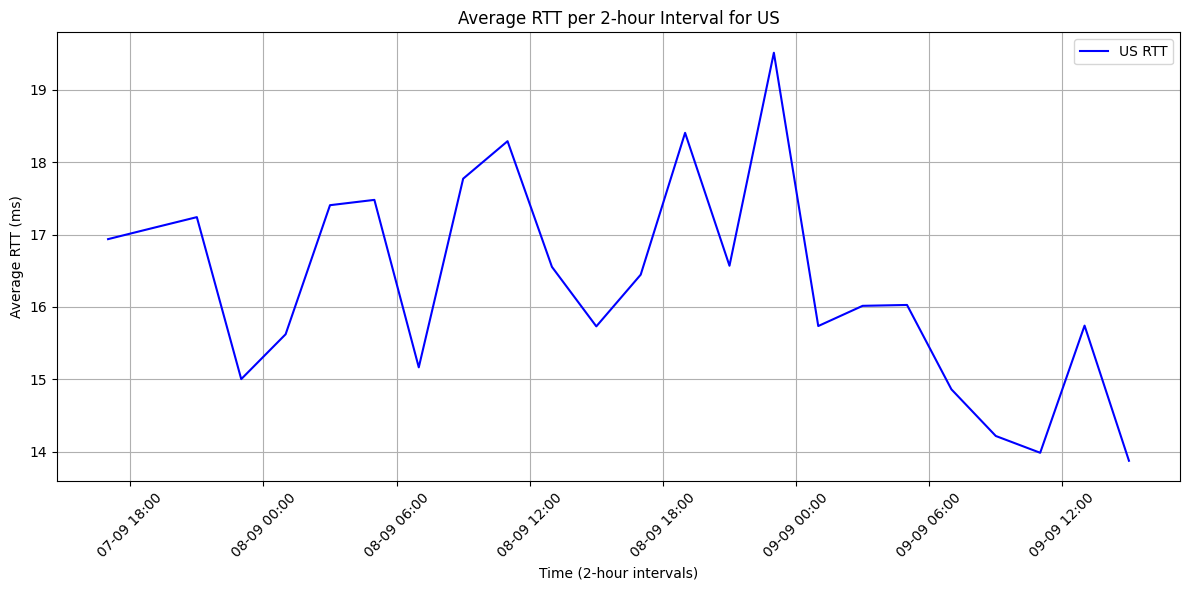

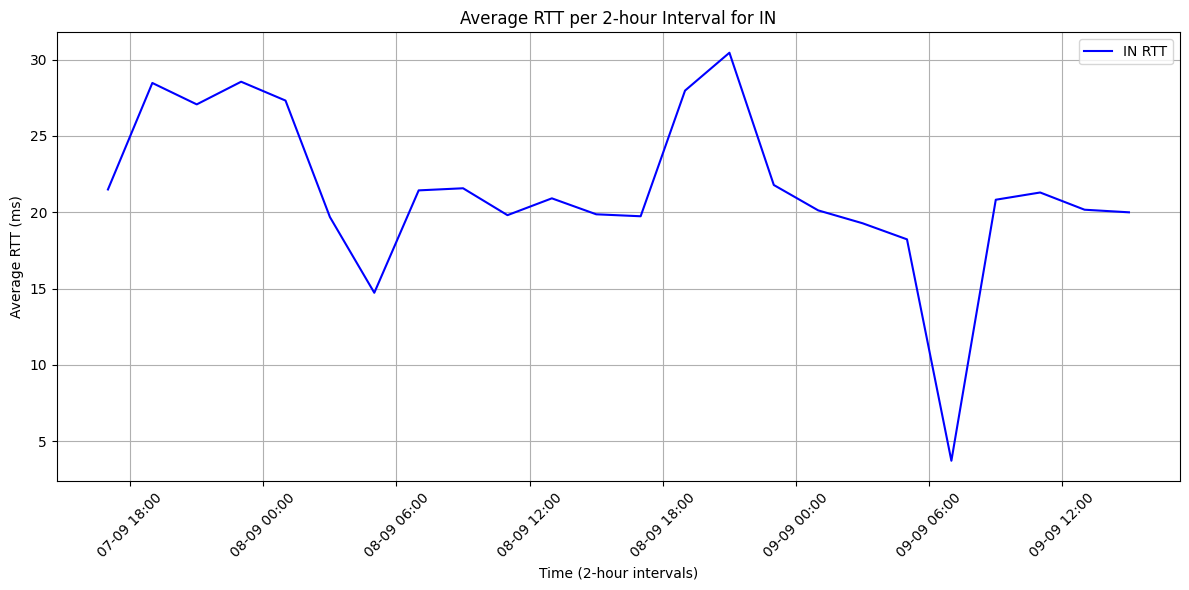

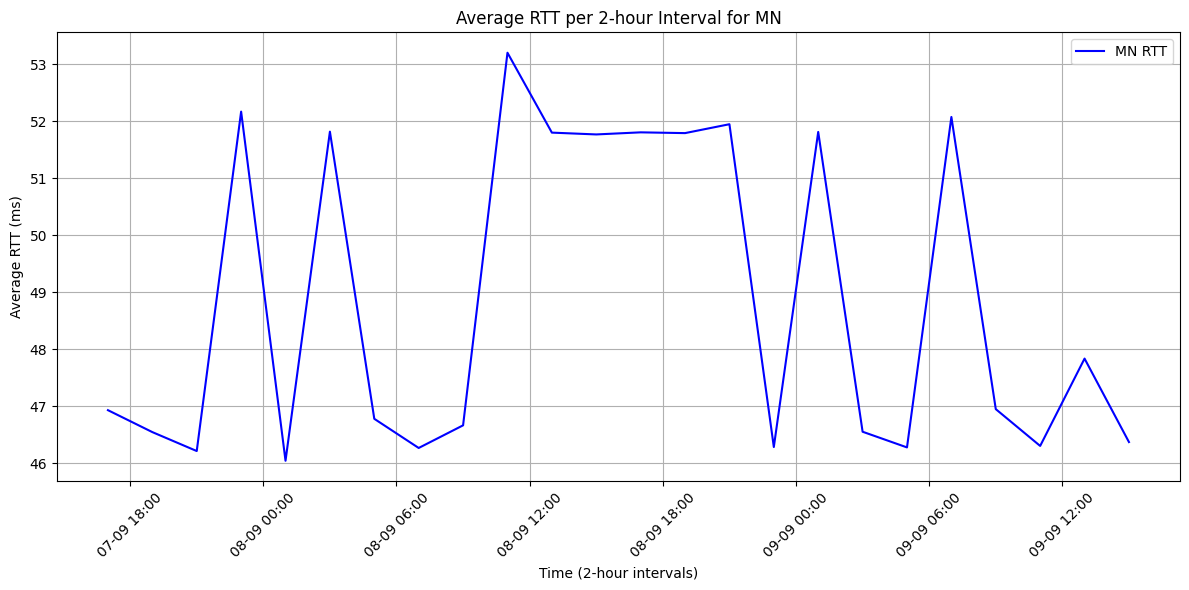

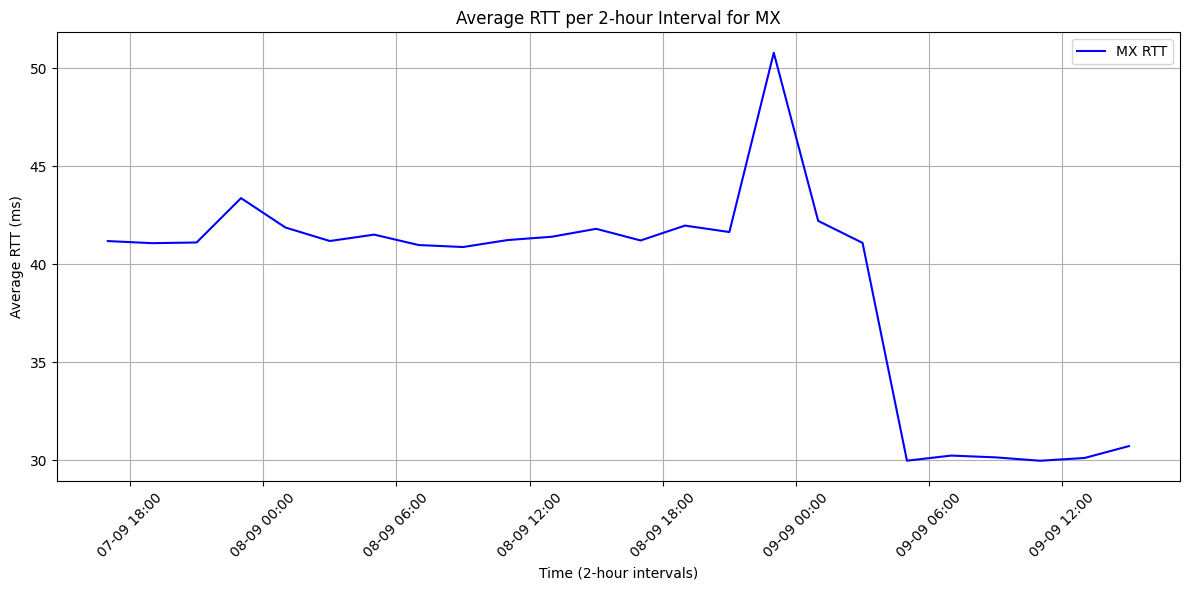

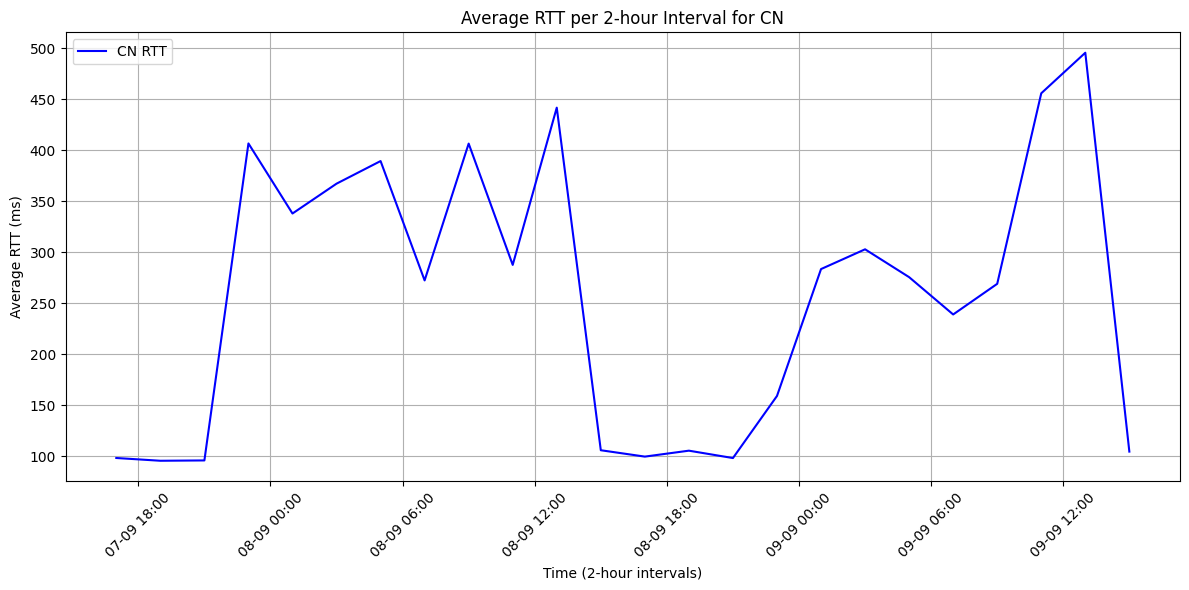

In [42]:
plot_rtt_by_country(destination_country_probes, min_rtt=0)

2. Variação da Quantidade de Saltos ao Longo do Tempo

a. Comparação da quantidade de saltos das probes para um mesmo destino

In [47]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from math import floor

# Helper function to bin timestamps into 2-hour intervals
def bin_timestamp_to_interval(timestamp, interval_hours=2):
    interval_seconds = interval_hours * 3600
    return floor(timestamp / interval_seconds) * interval_seconds

def plot_hops_for_destination(destination_country_probes, destination_name, min_hops=0):
    """
    Plots the number of hops over time for a specified destination.
    
    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - destination_name: The name of the destination for which to plot the hops data.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    if destination_name not in destination_country_probes:
        print(f"No data available for destination {destination_name}.")
        return

    # Initialize dictionary to store the number of hops and timestamps
    hops_data = defaultdict(list)

    # Collect hops data
    for country, probes in destination_country_probes[destination_name].items():
        for probe in probes:
            if probe.result:
                num_hops = len(probe.result)  # Count the number of hops
                timestamp = probe.timestamp
                if num_hops >= min_hops and timestamp is not None:  # Only consider hops greater than the minimum
                    interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp into 2-hour intervals
                    hops_data[interval_timestamp].append(num_hops)

    # Calculate average number of hops for each 2-hour interval
    average_hops = {timestamp: sum(hops) / len(hops) for timestamp, hops in hops_data.items()}

    # Sort timestamps for plotting
    sorted_timestamps = sorted(average_hops.keys())
    sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
    sorted_hops = [average_hops[timestamp] for timestamp in sorted_timestamps]

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_times, sorted_hops, linestyle='-', color='b', label='Average Hops')

    # Format the x-axis to display date and time correctly
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Labels and formatting
    plt.xlabel('Time (2-hour intervals)')
    plt.ylabel('Average Number of Hops')
    plt.title(f'Average Number of Hops per 2-hour Interval for Destination: {destination_name}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

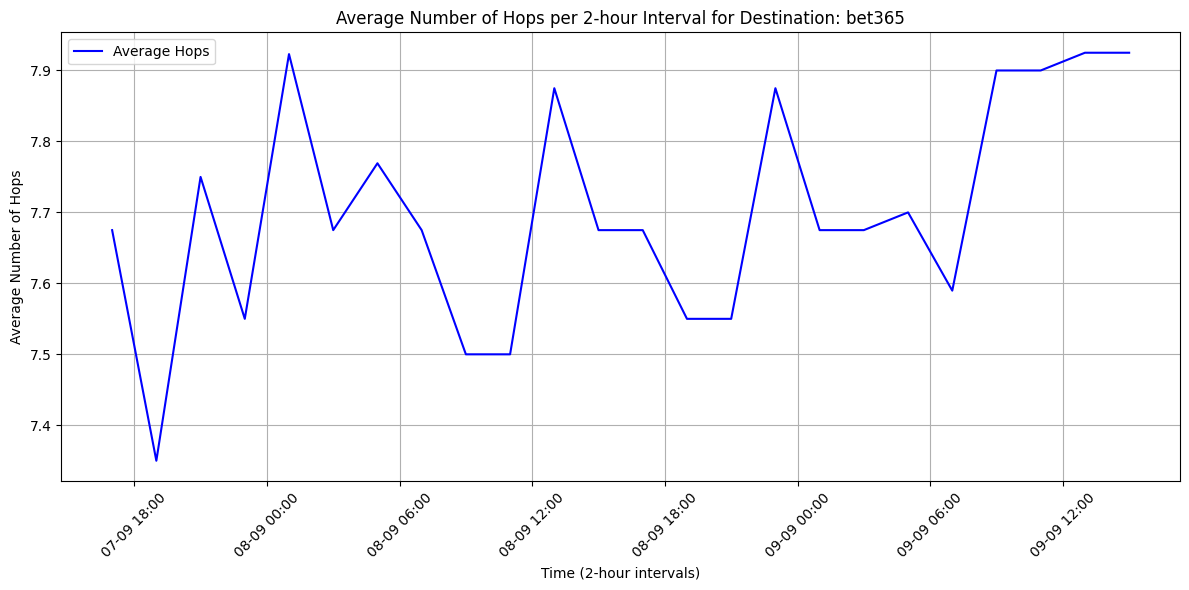

In [48]:
plot_hops_for_destination(destination_country_probes, destination_name='bet365', min_hops=0)

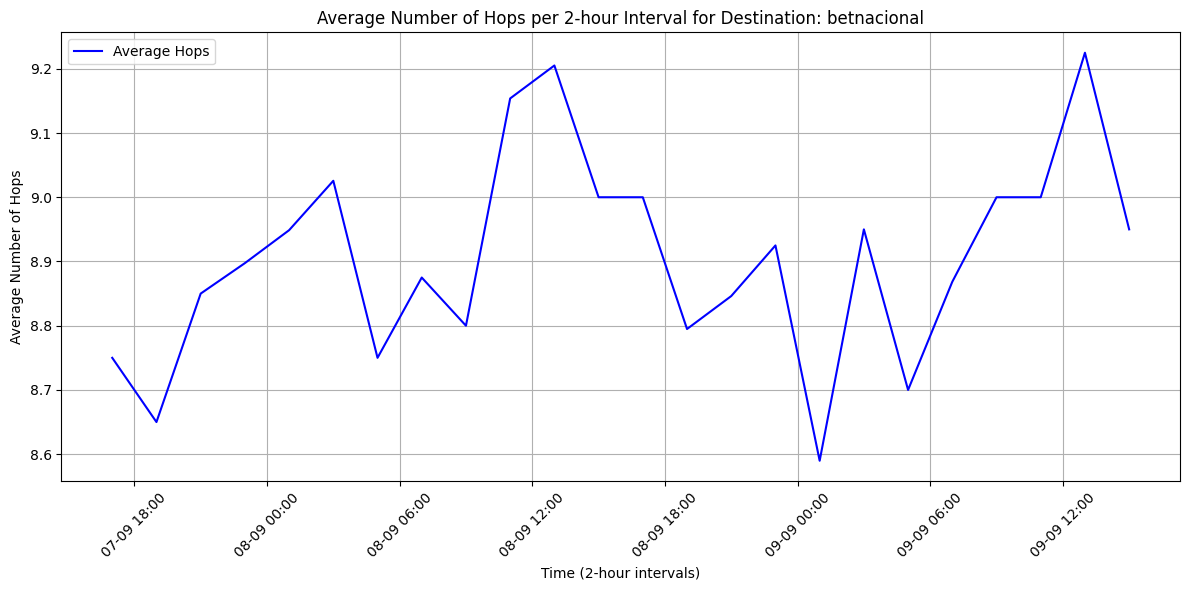

In [49]:
plot_hops_for_destination(destination_country_probes, destination_name='betnacional', min_hops=0)

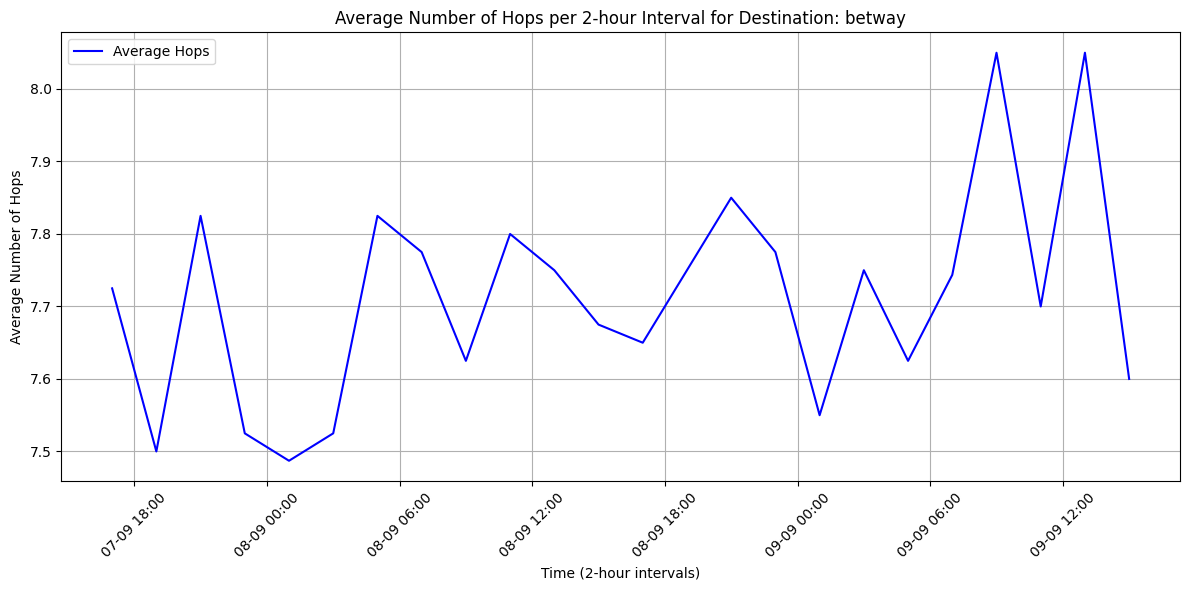

In [50]:
plot_hops_for_destination(destination_country_probes, destination_name='betway', min_hops=0)

b. Comparação da quantidade de saltos para todos os destinos medidos

In [53]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from math import floor

# Helper function to bin timestamps into 2-hour intervals
def bin_timestamp_to_interval(timestamp, interval_hours=2):
    interval_seconds = interval_hours * 3600
    return floor(timestamp / interval_seconds) * interval_seconds

def plot_hops_for_all_destinations(destination_country_probes, min_hops=0):
    """
    Plots the number of hops over time for all destinations.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    hops_data = defaultdict(lambda: defaultdict(list))

    # Collect hops data for all destinations
    for destination, countries in destination_country_probes.items():
        for country, probes in countries.items():
            for probe in probes:
                if probe.result:
                    num_hops = len(probe.result)  # Count the number of hops
                    timestamp = probe.timestamp
                    if num_hops >= min_hops and timestamp is not None:  # Only consider hops greater than the minimum
                        interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp into 2-hour intervals
                        hops_data[destination][interval_timestamp].append(num_hops)

    # Plotting
    plt.figure(figsize=(12, 8))
    
    colors = plt.get_cmap('tab20').colors  # Using a larger colormap for more colors
    color_index = 0
    
    for destination, intervals in hops_data.items():
        # Prepare data for plotting
        timestamps = sorted(intervals.keys())
        average_hops = [sum(intervals[interval]) / len(intervals[interval]) for interval in timestamps]
        
        # Convert timestamps to datetime objects for plotting
        sorted_times = [datetime.fromtimestamp(ts) for ts in timestamps]

        # Line plot of number of hops vs timestamp for each destination
        plt.plot(sorted_times, average_hops, linestyle='-', color=colors[color_index % len(colors)], label=destination)
        color_index += 1

    # Format the x-axis to display date and time correctly
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Labels and formatting
    plt.xlabel('Timestamp')
    plt.ylabel('Average Number of Hops')
    plt.title('Average Number of Hops per 2-hour Interval for All Destinations')
    plt.legend(title="Destinations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


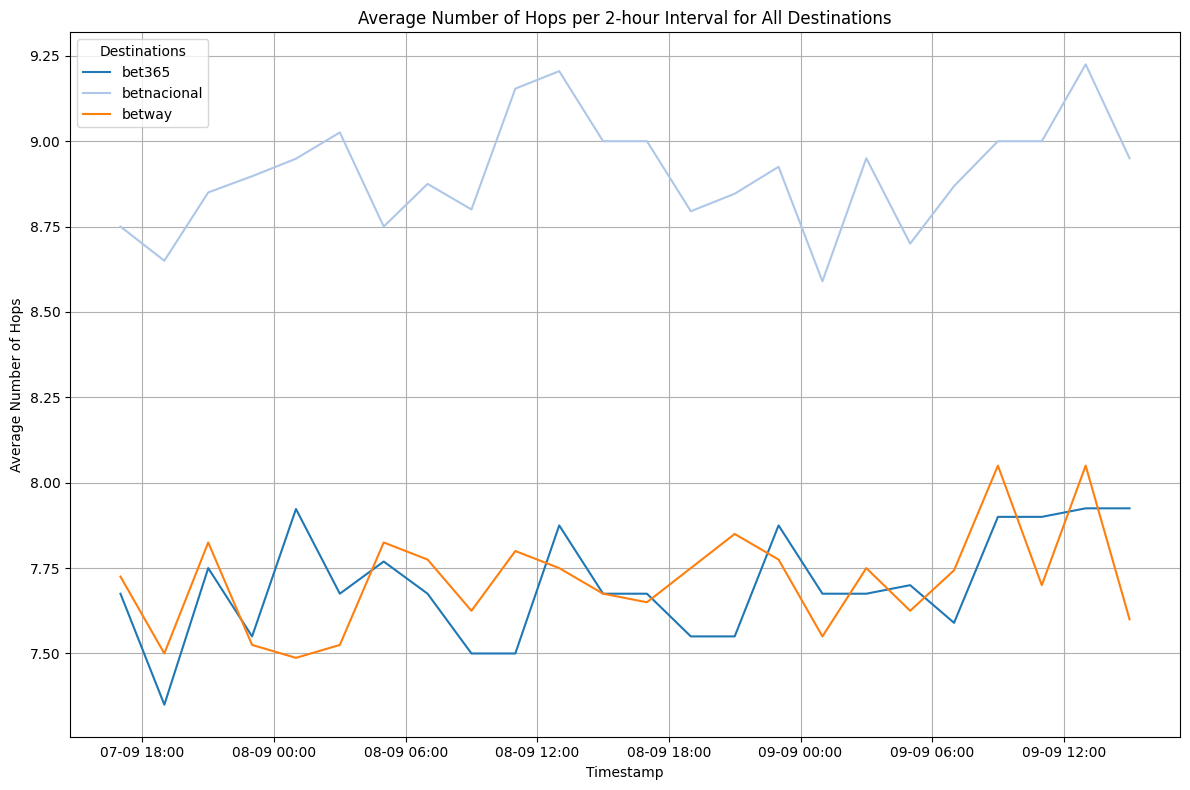

In [54]:
plot_hops_for_all_destinations(destination_country_probes, min_hops=0)

c. Gráficos por Continente e País

In [61]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from math import floor

# Helper function to bin timestamps into 2-hour intervals
def bin_timestamp_to_interval(timestamp, interval_hours=2):
    interval_seconds = interval_hours * 3600
    return floor(timestamp / interval_seconds) * interval_seconds

def plot_hops_by_continent(destination_country_probes, continents, min_hops=0):
    """
    Plots the number of hops over time for each continent and its countries.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - continents: A dictionary mapping continent names to lists of country codes.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    # Create a reverse mapping from country code to continent
    country_to_continent = {}
    for continent, countries in continents.items():
        for country_code in countries:
            country_to_continent[country_code] = continent

    # Initialize data storage
    hops_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Collect hops data by continent and country
    for destination, countries in destination_country_probes.items():
        for country, probes in countries.items():
            continent = country_to_continent.get(country)
            if continent:
                for probe in probes:
                    if probe.result:
                        num_hops = len(probe.result)  # Count the number of hops
                        timestamp = probe.timestamp
                        if num_hops >= min_hops and timestamp is not None:  # Only consider hops greater than the minimum
                            interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp into 2-hour intervals
                            hops_data[continent][country][interval_timestamp].append(num_hops)

    # Plotting
    for continent, countries in hops_data.items():
        plt.figure(figsize=(14, 8))
        
        colors = plt.get_cmap('tab20').colors  # Using a larger colormap for more colors
        color_index = 0

        for country, intervals in countries.items():
            # Prepare data for plotting
            timestamps = sorted(intervals.keys())
            average_hops = [sum(intervals[interval]) / len(intervals[interval]) for interval in timestamps]
            
            # Convert timestamps to datetime objects for plotting
            sorted_times = [datetime.fromtimestamp(ts) for ts in timestamps]

            # Line plot of number of hops vs timestamp for each country
            plt.plot(sorted_times, average_hops, linestyle='-', color=colors[color_index % len(colors)], label=country)
            color_index += 1

        # Format the x-axis to display date and time correctly
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        # Labels and formatting
        plt.xlabel('Timestamp')
        plt.ylabel('Average Number of Hops')
        plt.title(f'Average Number of Hops per 2-hour Interval - {continent}')
        plt.legend(title="Countries")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [67]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from math import floor

# Helper function to bin timestamps into 2-hour intervals
def bin_timestamp_to_interval(timestamp, interval_hours=2):
    interval_seconds = interval_hours * 3600
    return floor(timestamp / interval_seconds) * interval_seconds

def plot_hops_by_country(destination_country_probes, min_hops=0):
    """
    Plots the number of hops over time for each country across all destinations.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    
    continents = {
    "South America": ["BR", "UY", "CL"],
    "Asia": ["CN", "MN", "IN"],
    "North America": ["US", "CN", "MX"]
    }
    # Initialize data storage
    hops_data = defaultdict(lambda: defaultdict(list))

    # Collect hops data by country
    for destination, countries in destination_country_probes.items():
        for country, probes in countries.items():
            if not any(country in countries for countries in continents.values()):
                continue
            for probe in probes:
                if probe.result:
                    num_hops = len(probe.result)  # Count the number of hops
                    timestamp = probe.timestamp
                    if num_hops >= min_hops and timestamp is not None:  # Only consider hops greater than the minimum
                        interval_timestamp = bin_timestamp_to_interval(timestamp)  # Bin timestamp into 2-hour intervals
                        hops_data[country][interval_timestamp].append(num_hops)

    # Plotting
    for country, intervals in hops_data.items():
        plt.figure(figsize=(14, 8))

        # Prepare data for plotting
        timestamps = sorted(intervals.keys())
        average_hops = [sum(intervals[interval]) / len(intervals[interval]) for interval in timestamps]
        
        # Convert timestamps to datetime objects for plotting
        sorted_times = [datetime.fromtimestamp(ts) for ts in timestamps]

        # Line plot of number of hops vs timestamp for each country
        plt.plot(sorted_times, average_hops, linestyle='-', label=country, color='b')

        # Format the x-axis to display date and time correctly
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        # Labels and formatting
        plt.xlabel('Timestamp')
        plt.ylabel('Average Number of Hops')
        plt.title(f'Average Number of Hops per 2-hour Interval - {country}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

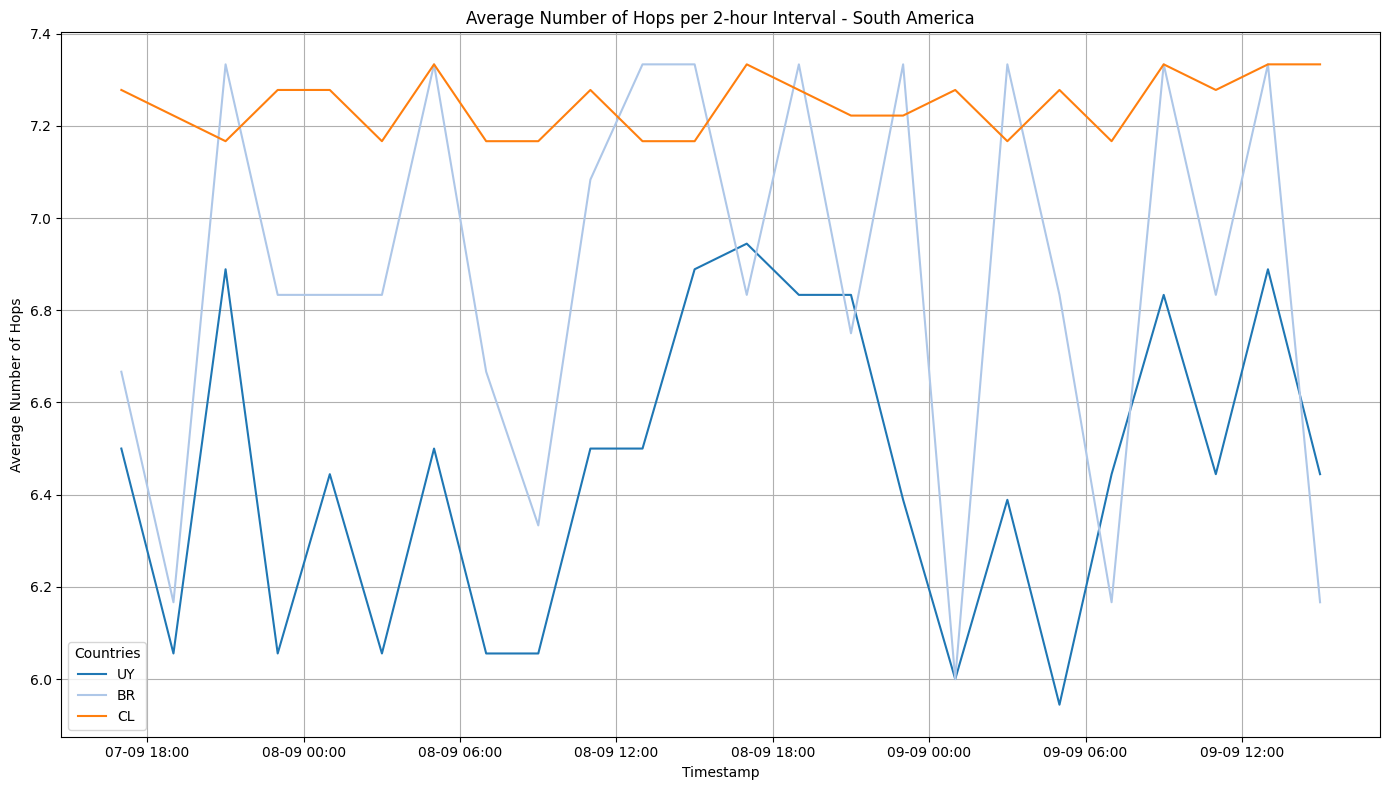

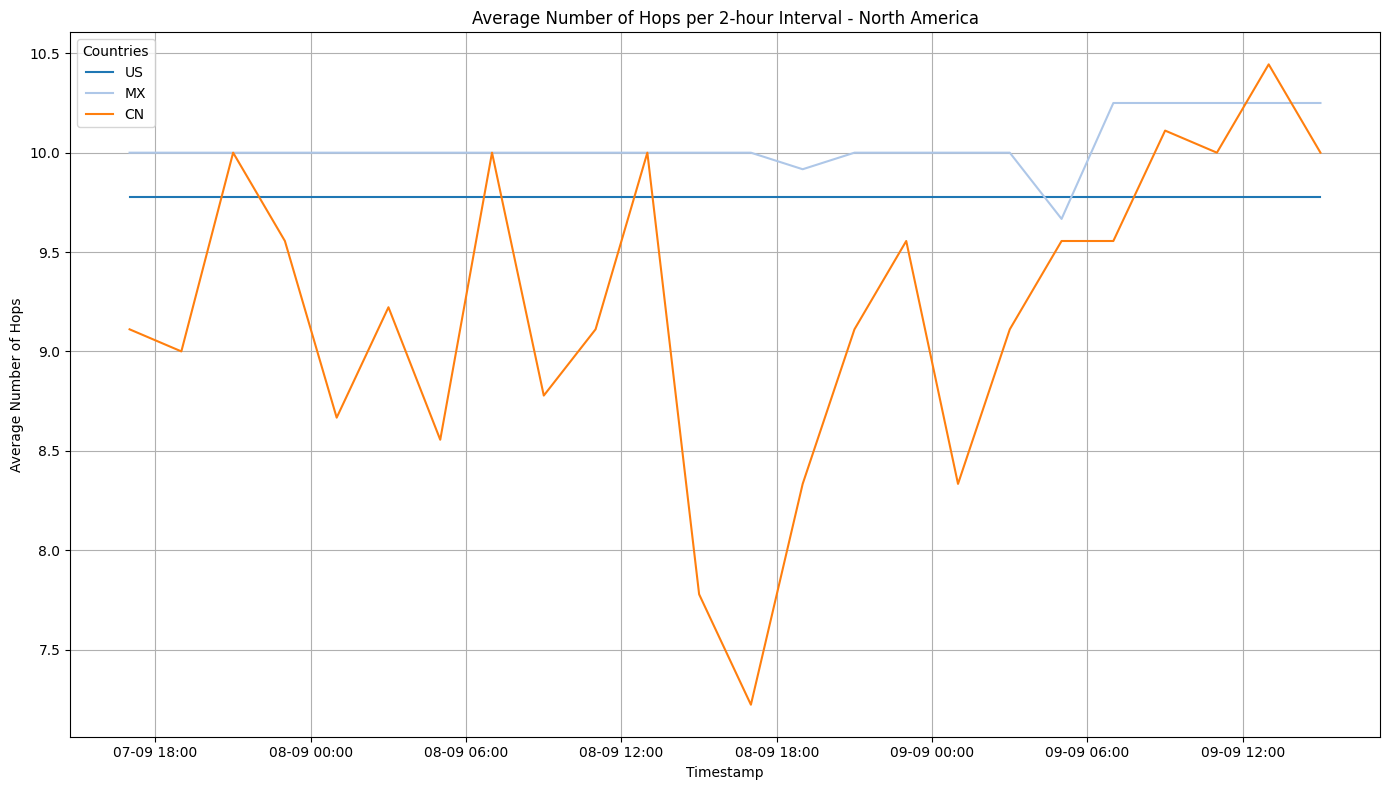

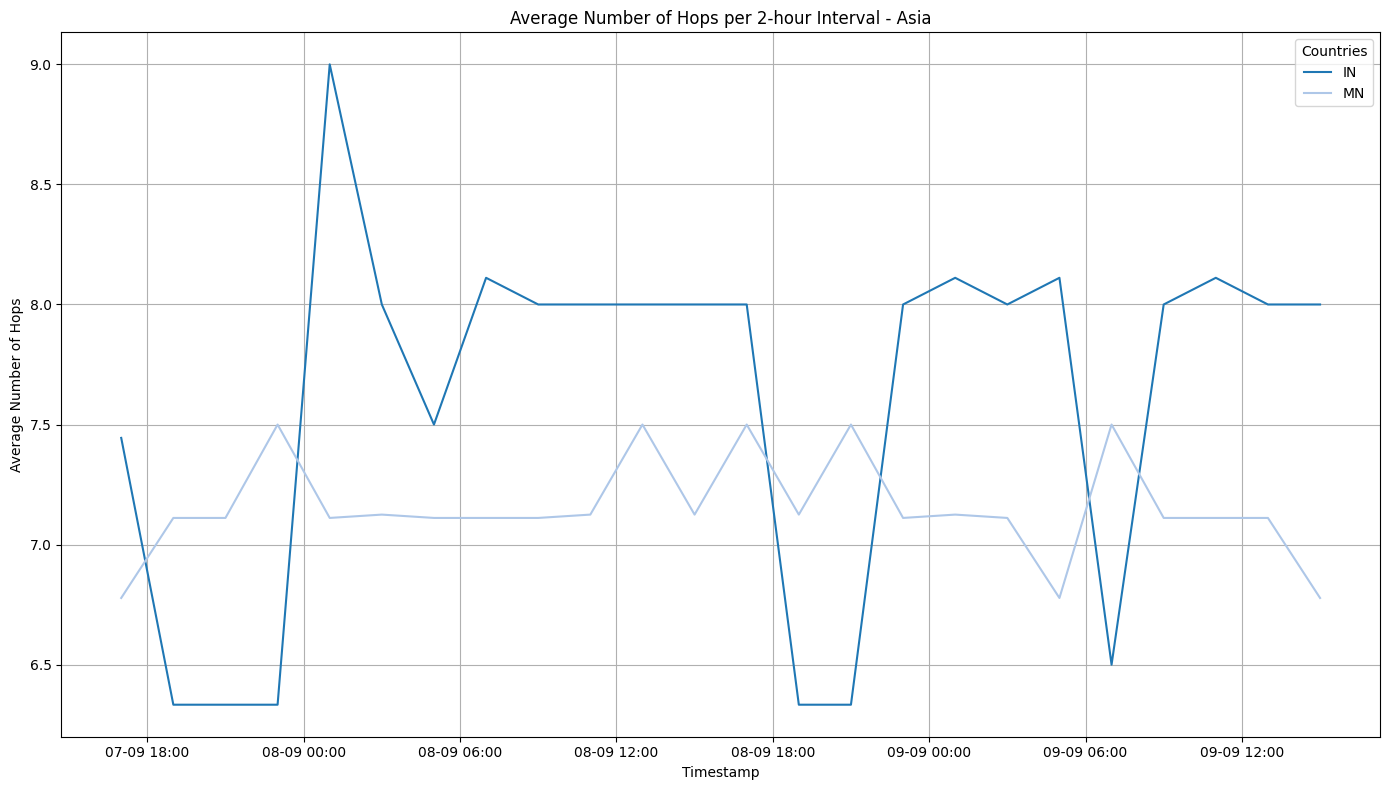

In [62]:
plot_hops_by_continent(destination_country_probes, continents, min_hops=0)

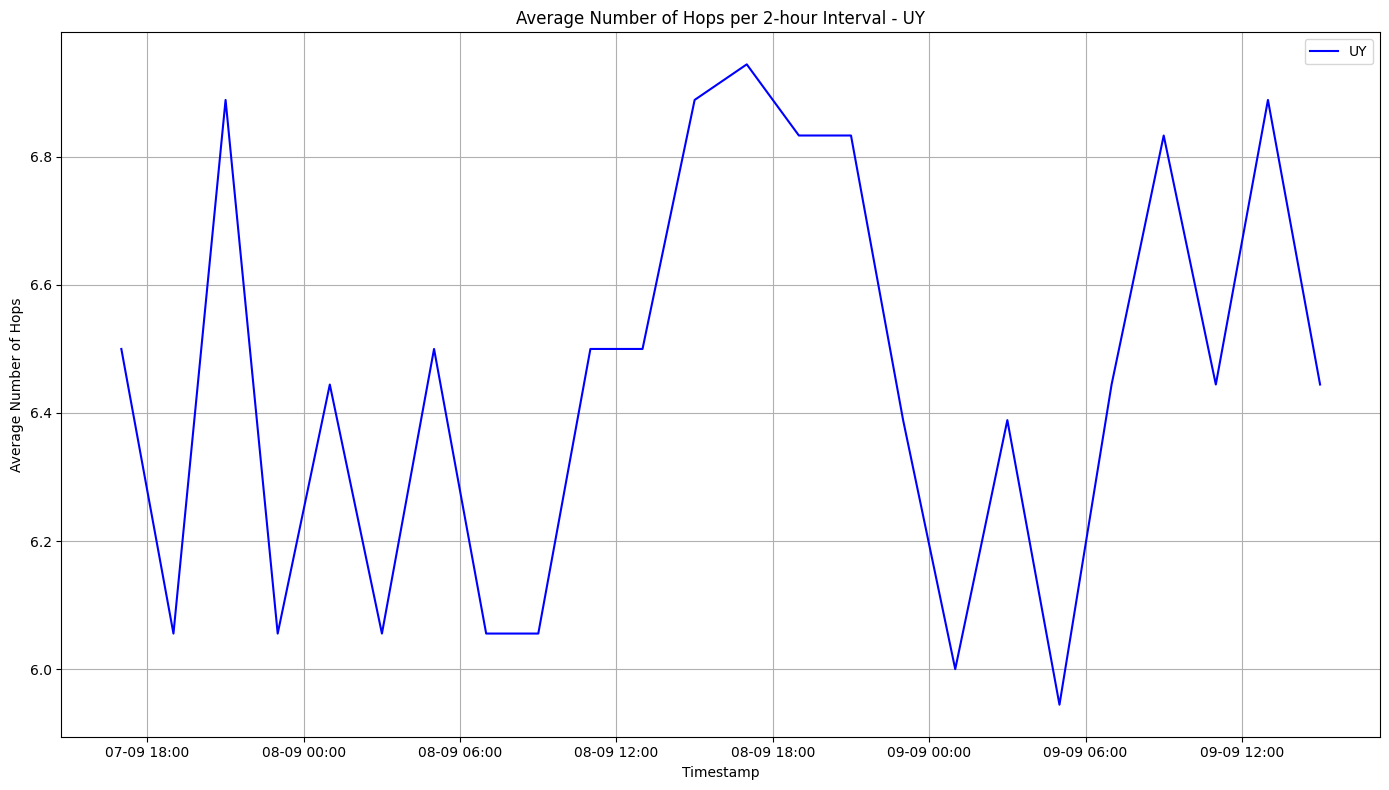

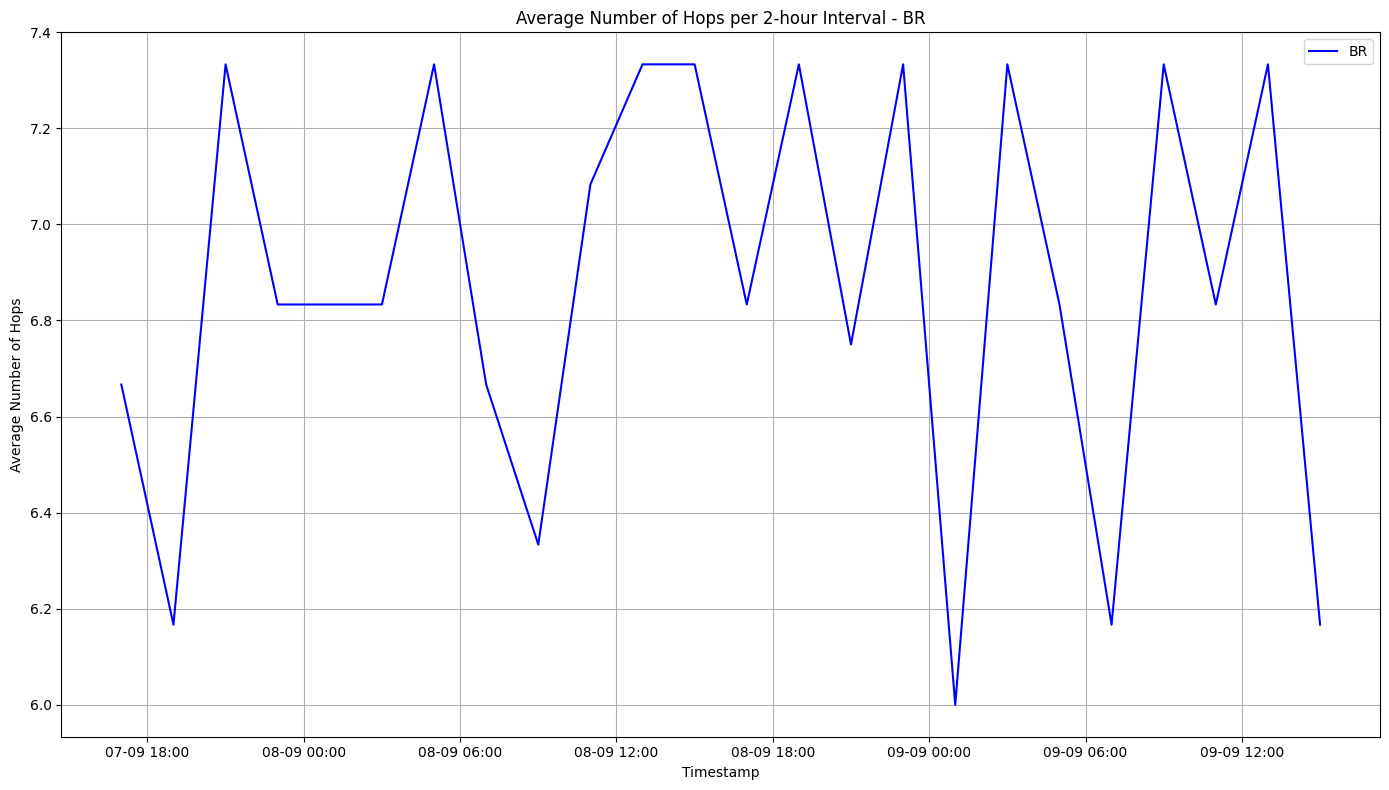

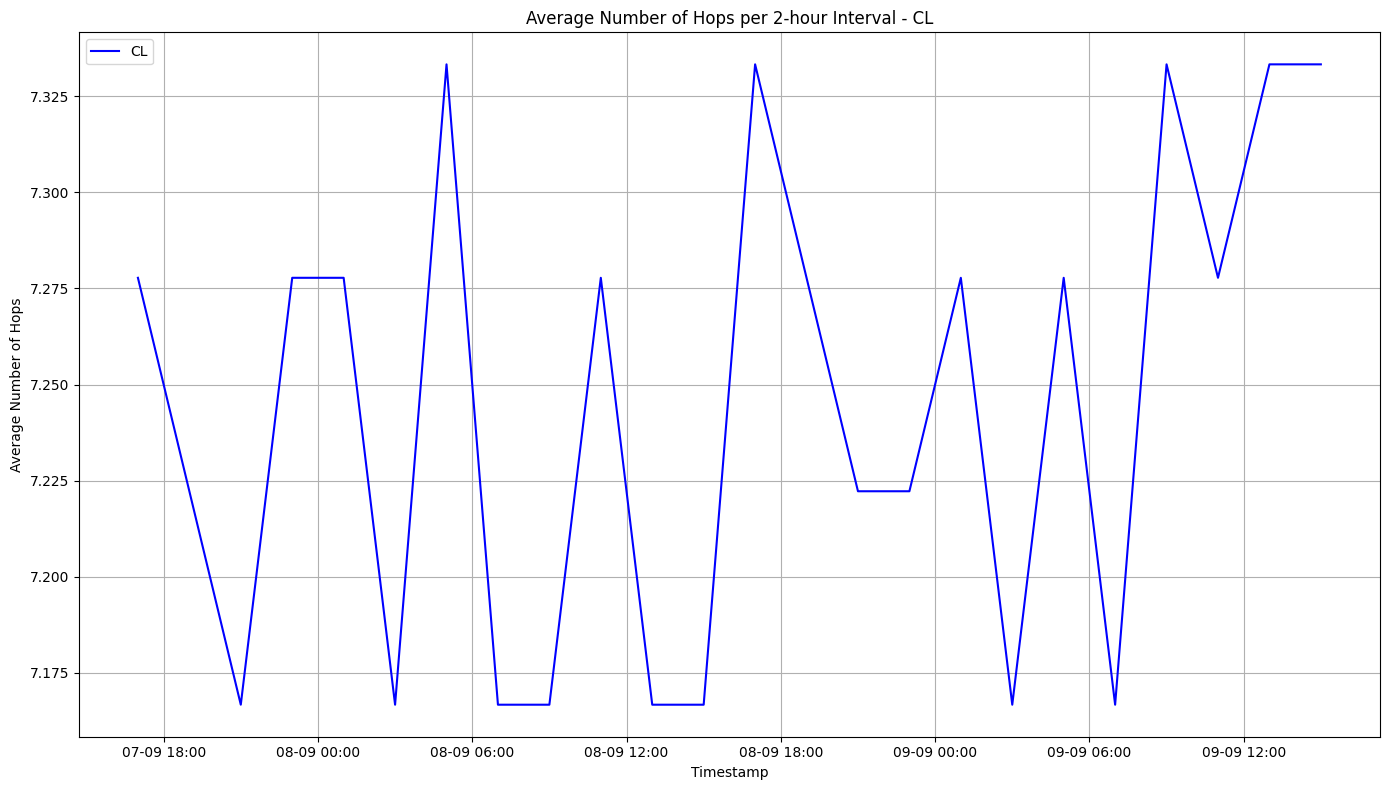

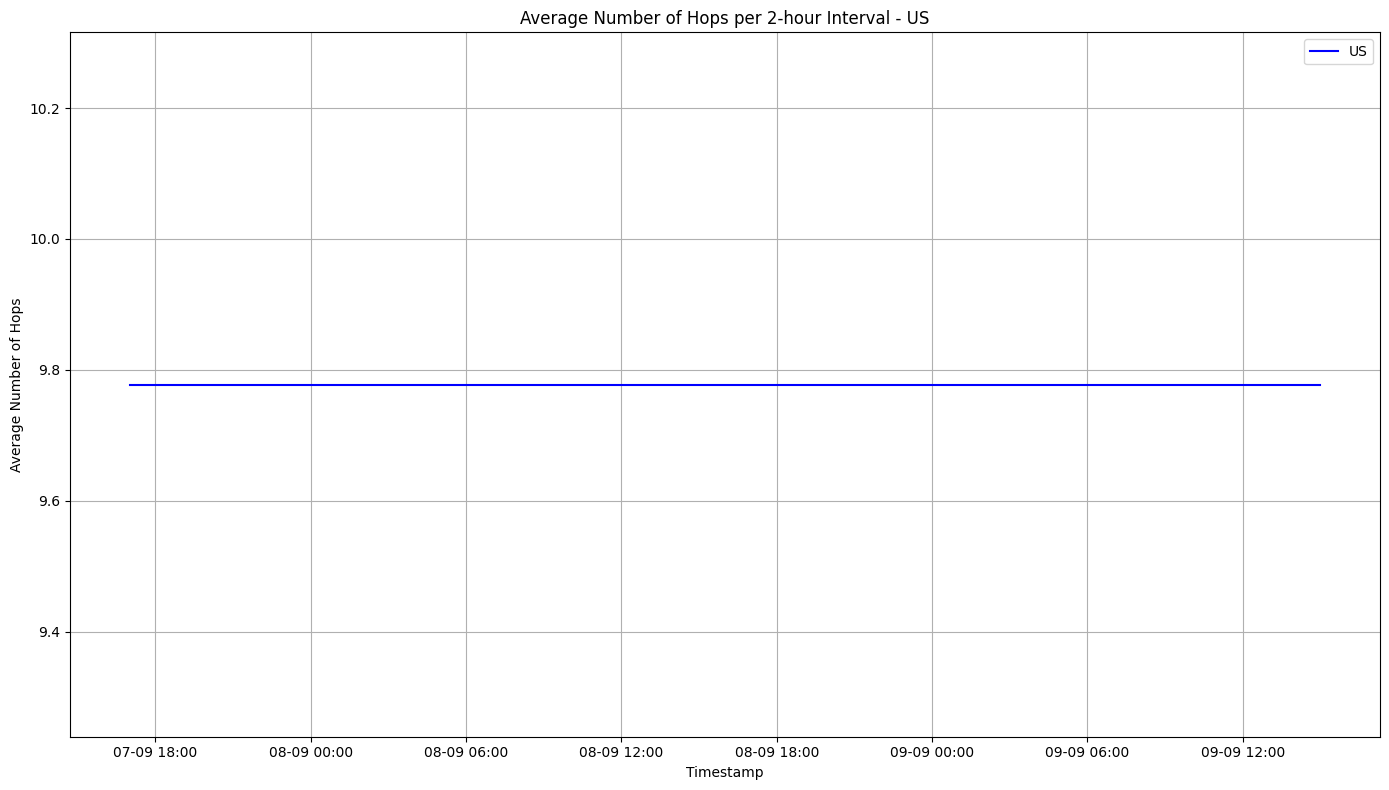

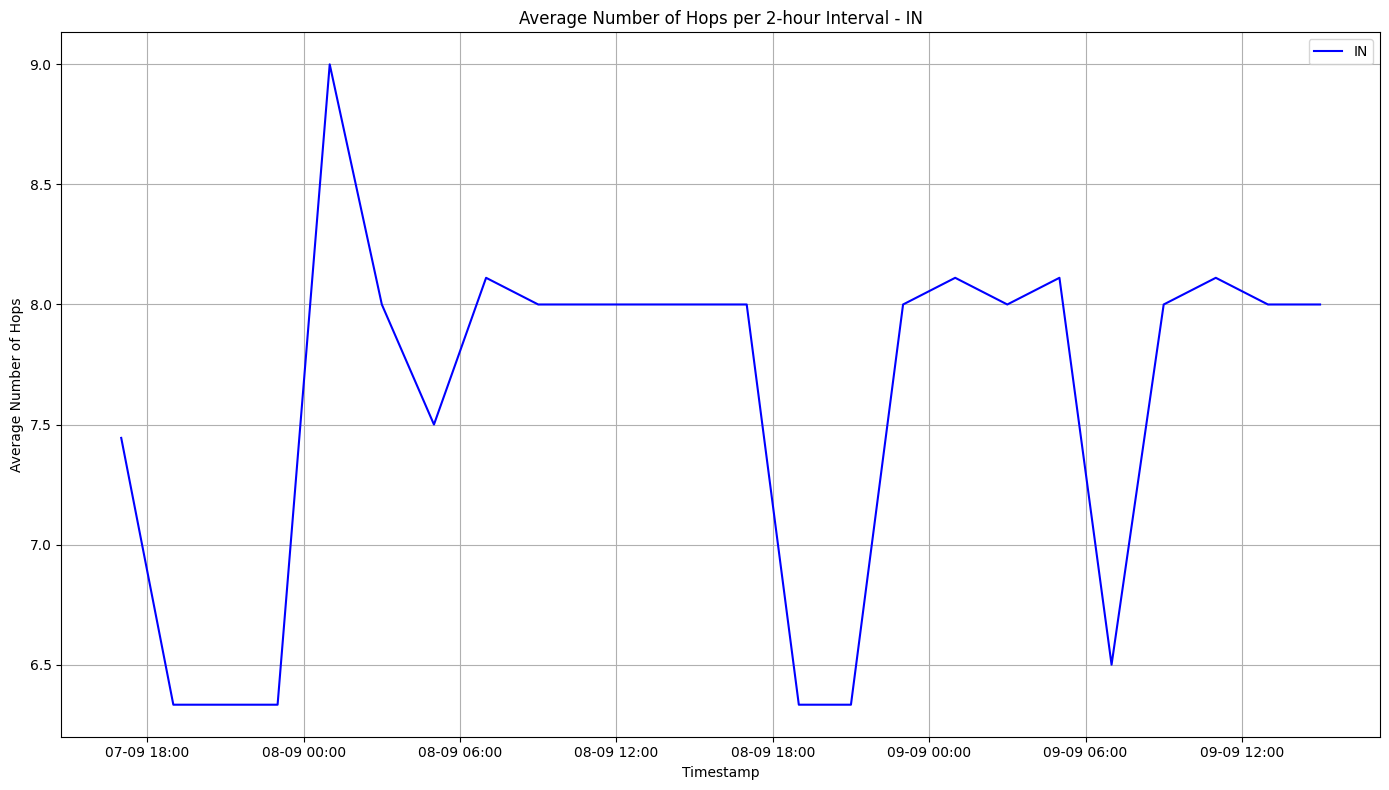

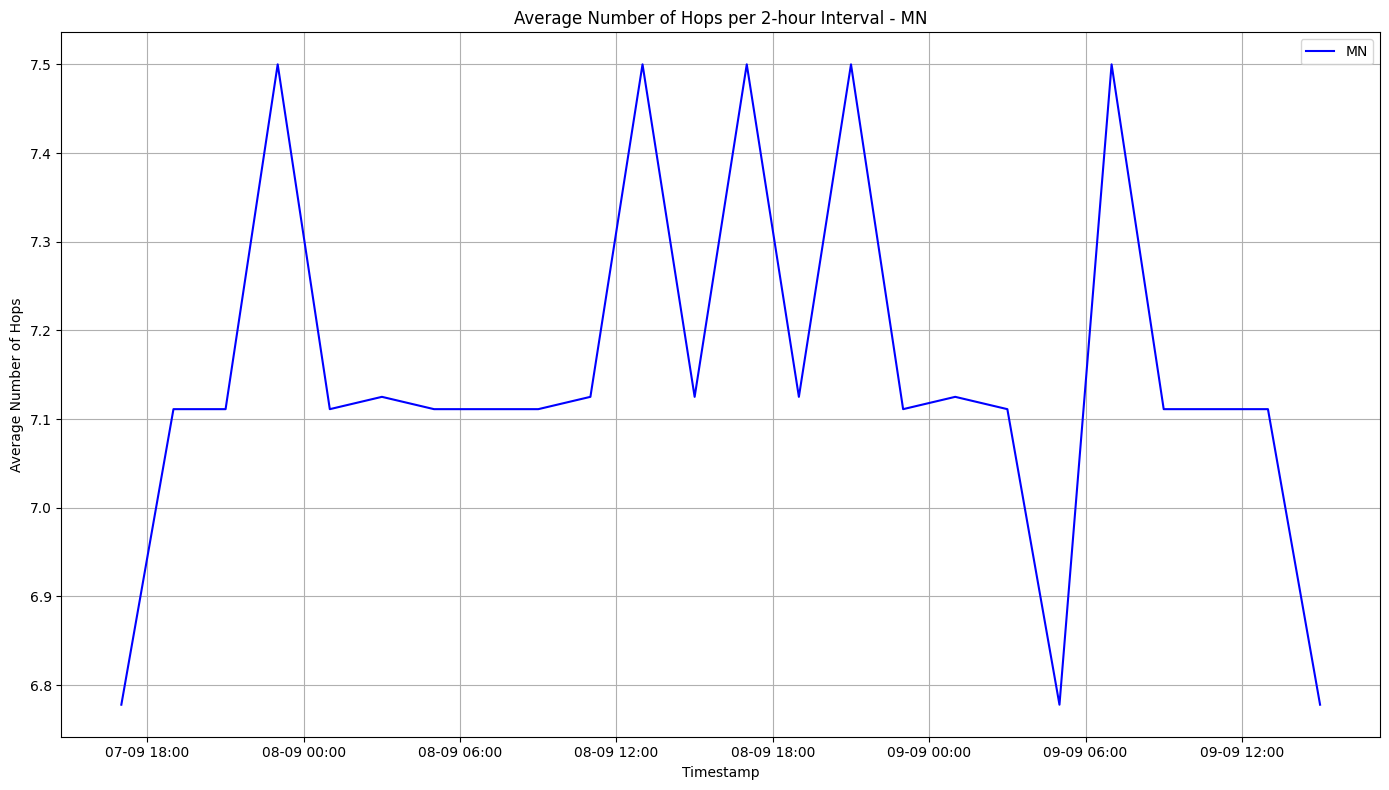

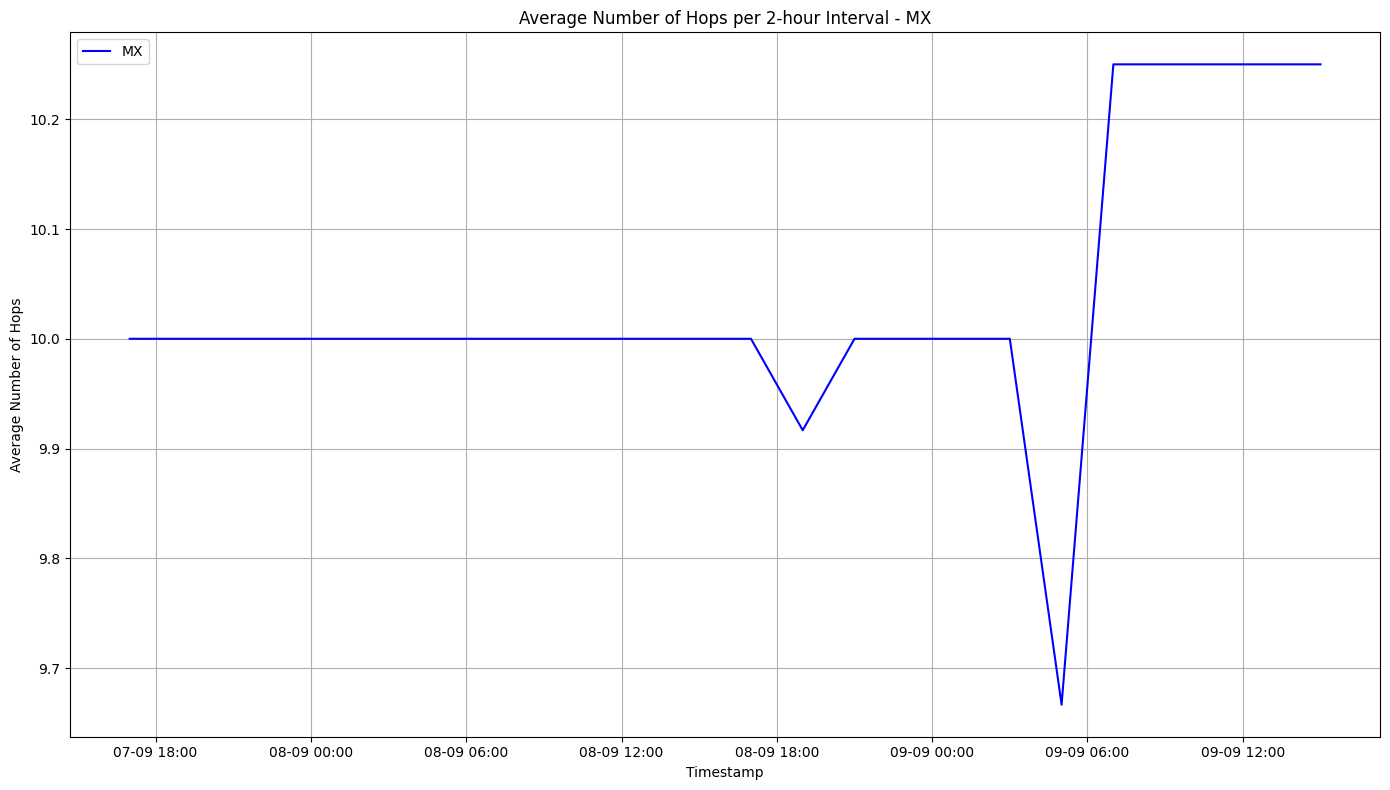

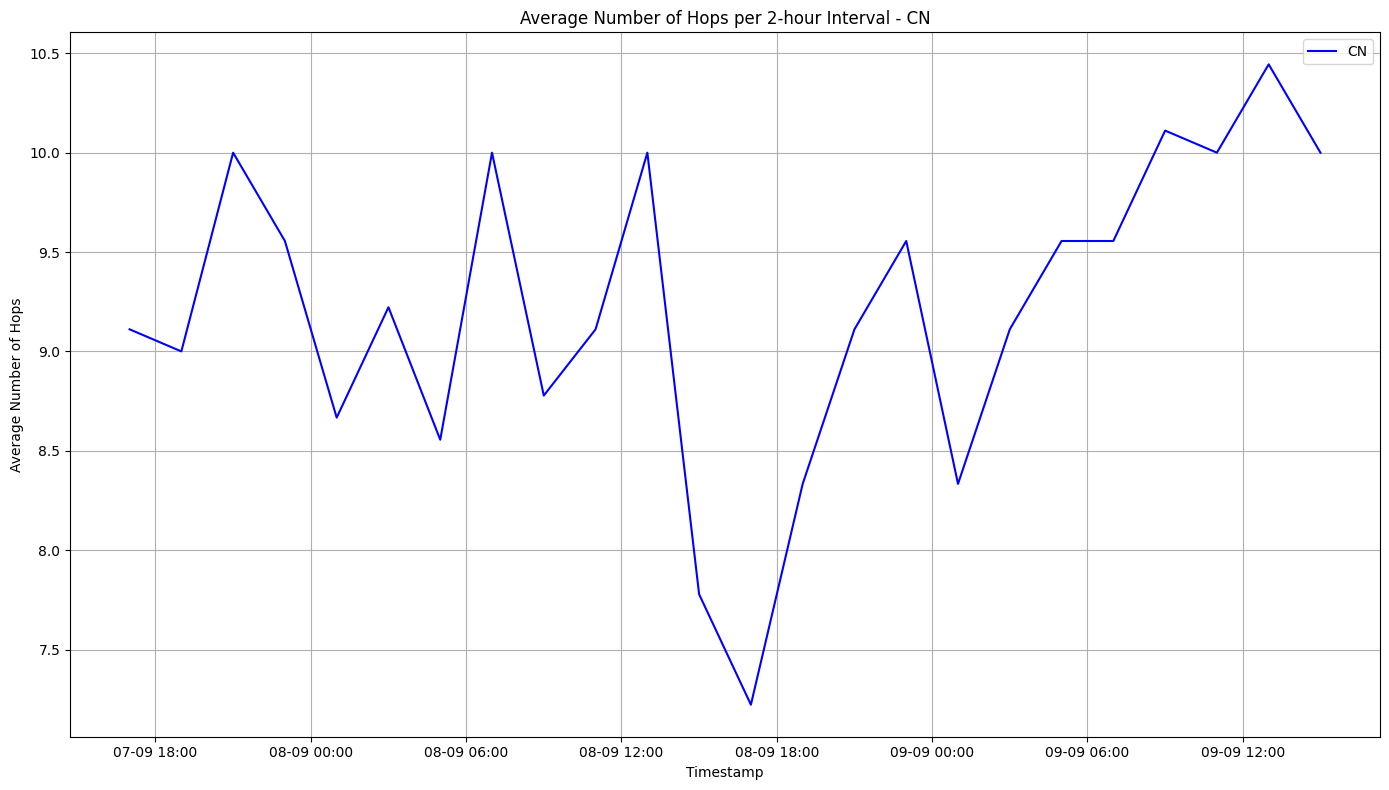

In [68]:
plot_hops_by_country(destination_country_probes, min_hops=0)

3. Correlação entre Latência e Número de Saltos

a. Por Destino

In [81]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from math import floor

# Helper function to bin timestamps into 2-hour intervals
def bin_timestamp_to_interval(timestamp, interval_hours=2):
    interval_seconds = interval_hours * 3600
    return floor(timestamp / interval_seconds) * interval_seconds

def plot_latency_vs_hops_by_destination(destination_country_probes, continents, min_rtt=2, min_hops=0):
    """
    Plots the correlation between latency and number of hops for each destination, with different colors for continents.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - continents: A dictionary mapping continents to a list of country codes.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    continent_colors = plt.get_cmap('tab20').colors  # Use a colormap with distinct colors
    continent_to_color = {continent: color for continent, color in zip(continents.keys(), continent_colors)}

    for destination, countries in destination_country_probes.items():
        # Initialize lists to store latency, hops, and continent data
        latencies = []
        hops = []
        continent_colors_list = []

        # Collect latency, hops, and continent data
        for country, probes in countries.items():
            # Determine continent for the current country
            continent = next((cont for cont, c_countries in continents.items() if country in c_countries), None)
            color = continent_to_color.get(continent, 'grey')  # Default to grey if continent not found

            for probe in probes:
                if probe.result:
                    # Calculate RTT
                    rtt = [p["result"][-1].get("rtt", 0) for p in probe.result if p.get("result")]
                    if rtt and max(rtt) > min_rtt:
                        latency = max(rtt)
                        num_hops = len(probe.result)
                        if num_hops >= min_hops:
                            latencies.append(latency)
                            hops.append(num_hops)
                            continent_colors_list.append(color)

        # Plotting
        if latencies and hops:
            plt.figure(figsize=(12, 8))

            # Scatter plot of latency vs number of hops with colors for continents
            scatter = plt.scatter(hops, latencies, c=continent_colors_list, alpha=0.7, edgecolors='w', s=100)

            # Create a legend for continents
            unique_colors = list(set(continent_colors_list))
            color_to_continent = {color: next((cont for cont, c_colors in continent_to_color.items() if c_colors == color), 'Unknown')
                                  for color in unique_colors}

            # Ensure the number of handles matches the number of labels
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
                       for color in unique_colors]
            labels = [color_to_continent[color] for color in unique_colors]

            plt.legend(handles=handles, labels=labels, title='Continents')

            plt.title(f'Latency vs Number of Hops - {destination}')
            plt.xlabel('Number of Hops')
            plt.ylabel('Latency (ms)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

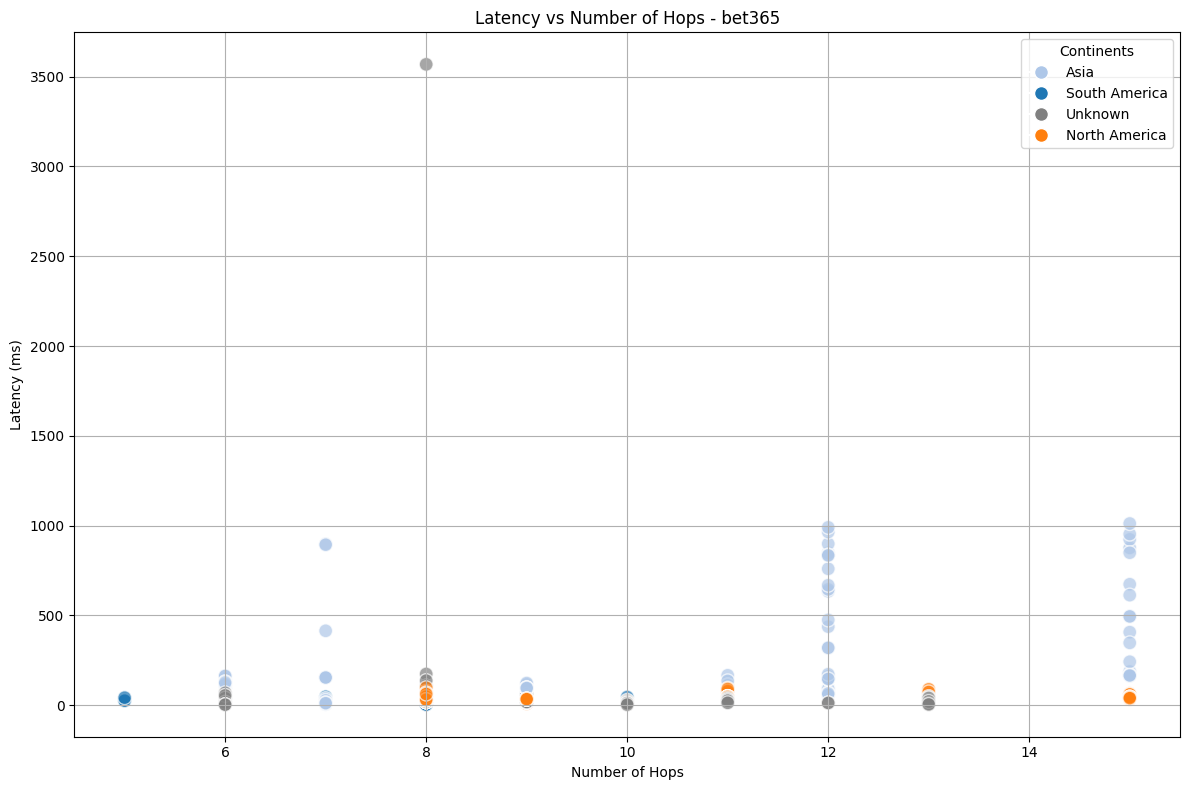

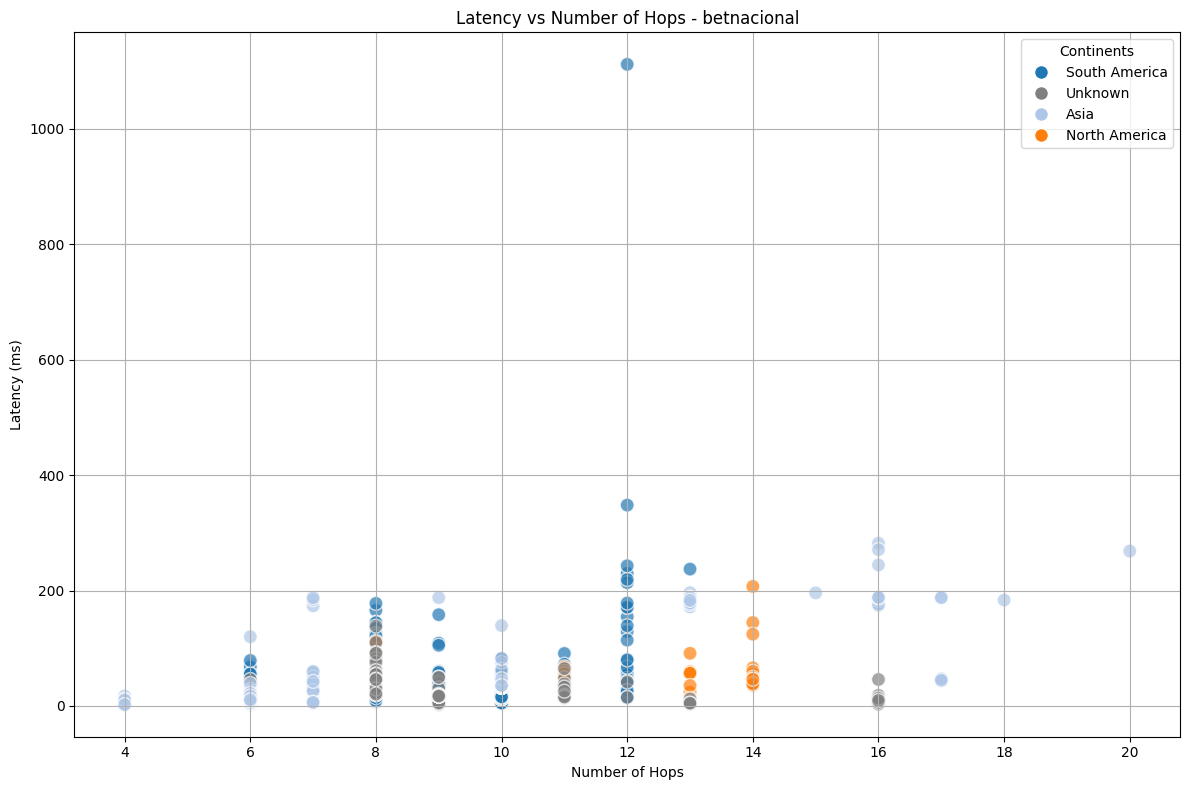

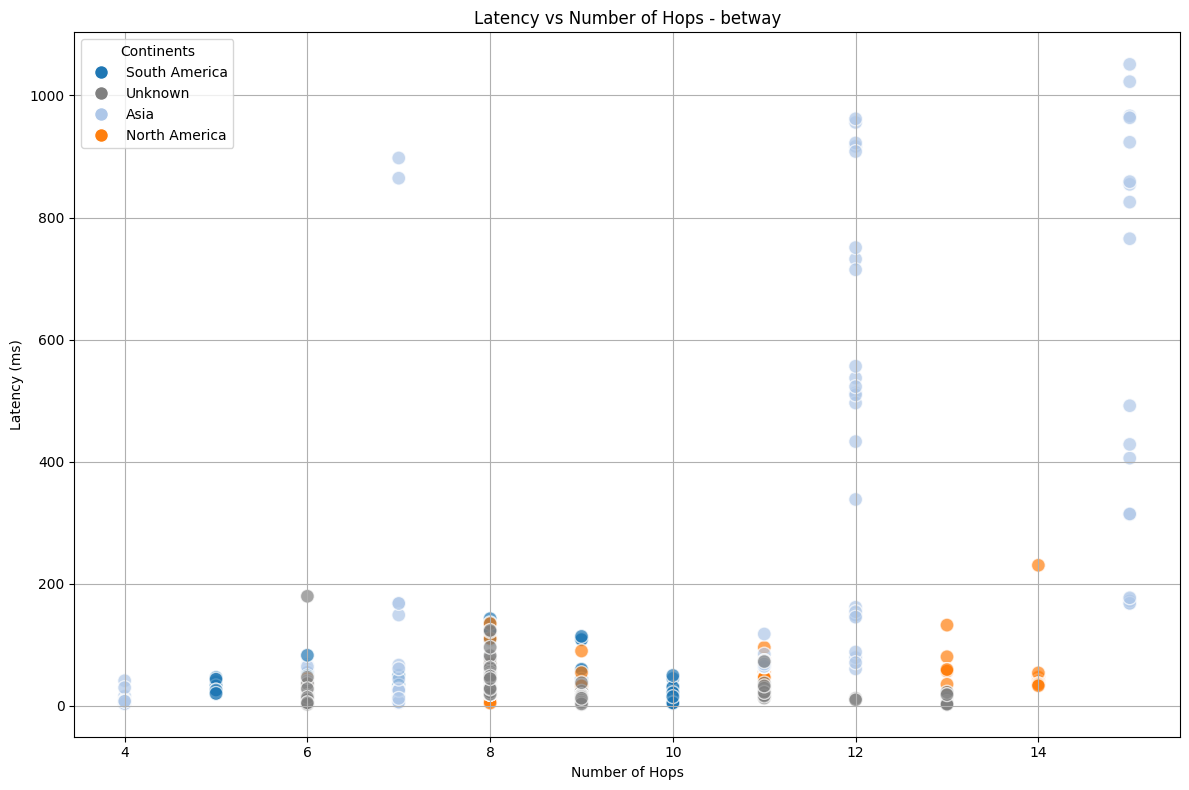

In [82]:
plot_latency_vs_hops_by_destination(destination_country_probes, continents=continents, min_rtt=2, min_hops=0)

b. Por Continente e País

In [99]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_latency_vs_hops_by_country(destination_country_probes, min_rtt=2, min_hops=0):
    """
    Plots the correlation between latency and number of hops for each country.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    plt.figure(figsize=(12, 8))
    plotted_countries = set()  # To keep track of countries that have already been plotted

    for destination, countries in destination_country_probes.items():
        for country, probes in countries.items():
            if not any(country in countries for countries in continents.values()):
                continue

            if country in plotted_countries:
                continue  # Skip if country has already been plotted

            latencies = []
            hops = []

            for probe in probes:
                if probe.result:
                    rtt = [p["result"][-1].get("rtt", 0) for p in probe.result if p.get("result")]
                    if rtt and max(rtt) > min_rtt:
                        latency = max(rtt)
                        num_hops = len(probe.result)
                        if num_hops >= min_hops:
                            latencies.append(latency)
                            hops.append(num_hops)

            if latencies and hops:
                plt.scatter(hops, latencies, alpha=0.7, edgecolors='w', label=country)
                plotted_countries.add(country)  # Add country to the set of plotted countries

    plt.title('Latency vs Number of Hops by Country')
    plt.xlabel('Number of Hops')
    plt.ylabel('Latency (ms)')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [95]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_latency_vs_hops_by_continent(destination_country_probes, continents, min_rtt=2, min_hops=0):
    """
    Plots the correlation between latency and number of hops for each continent.

    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - continents: A dictionary mapping continent names to lists of country codes.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    - min_hops: The minimum number of hops to consider for the plot. Default is 0.
    """
    # Create a mapping from country to continent
    country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}

    # Initialize a dictionary to store continent-specific data
    continent_data = defaultdict(list)

    for destination, countries in destination_country_probes.items():
        for country, probes in countries.items():
            continent = country_to_continent.get(country)
            if not continent:
                continue

            for probe in probes:
                if probe.result:
                    rtt = [p["result"][-1].get("rtt", 0) for p in probe.result if p.get("result")]
                    if rtt and max(rtt) > min_rtt:
                        latency = max(rtt)
                        num_hops = len(probe.result)
                        if num_hops >= min_hops:
                            continent_data[continent].append((num_hops, latency))

    # Plot the data
    plt.figure(figsize=(12, 8))
    color_map = plt.get_cmap('tab20')

    for i, (continent, data) in enumerate(continent_data.items()):
        if data:
            hops, latencies = zip(*data)
            plt.scatter(hops, latencies, alpha=0.7, edgecolors='w', color=color_map(i), label=continent)

    plt.title('Latency vs Number of Hops by Continent')
    plt.xlabel('Number of Hops')
    plt.ylabel('Latency (ms)')
    plt.legend(title='Continent')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

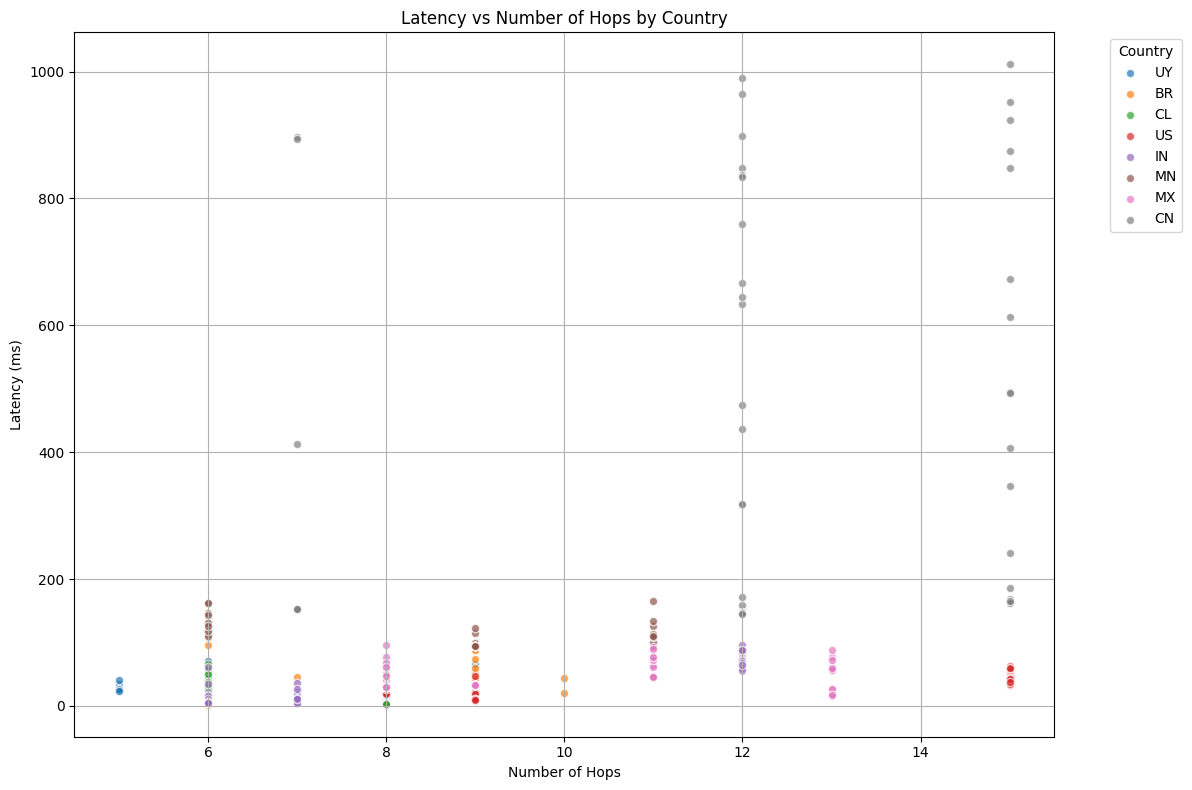

In [100]:
plot_latency_vs_hops_by_country(destination_country_probes, min_rtt=2, min_hops=0)

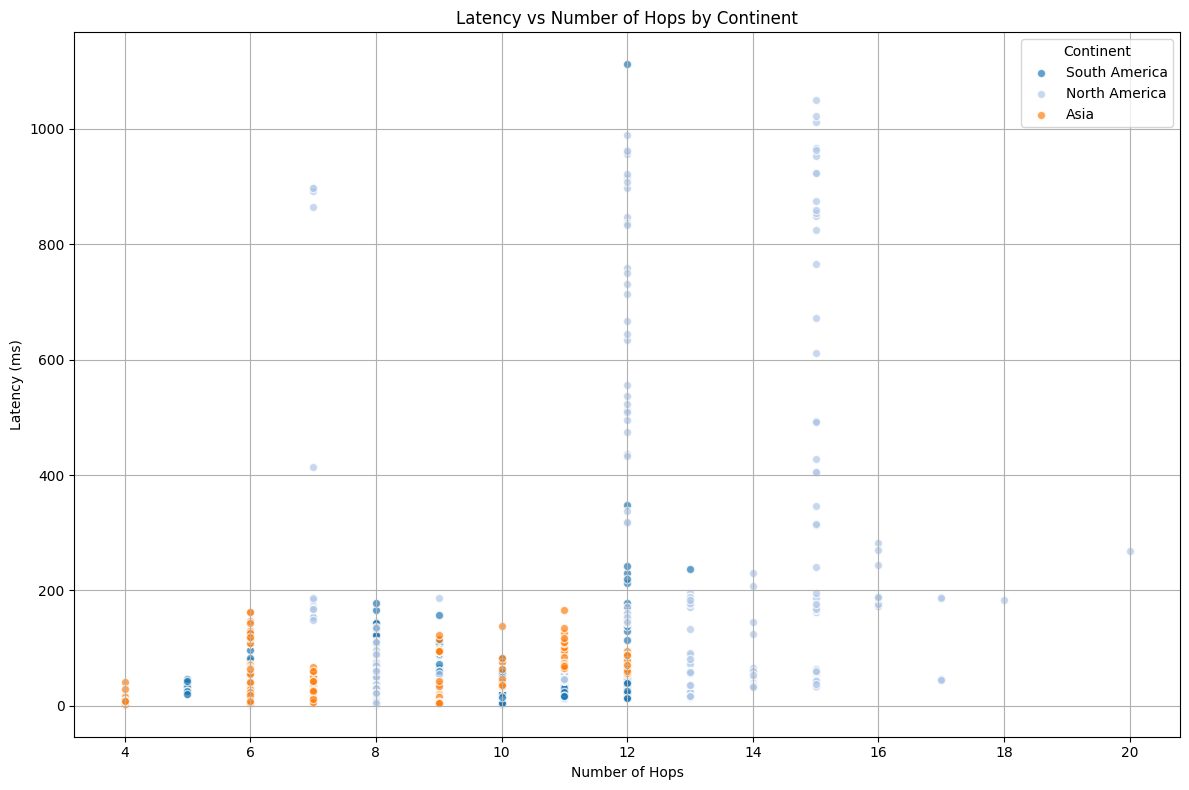

In [96]:
plot_latency_vs_hops_by_continent(destination_country_probes, continents, min_rtt=2, min_hops=0)